## Explainability Map Maker

1. Recall test results from data/*.pkl
2. Make stats (find best mae indices)
3. Draw

In [1]:
import os
from glob import glob
import random
from pathlib import Path
import pickle
from functools import partial
import numpy as np
import yaml

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme();
from IPython.display import clear_output
from celluloid import Camera

from sage.training.trainer import MRITrainer
from sage.visualization.vistool import plot_vismap
from sage.visualization.utils import check_type
from sage.config import load_config
from utils.analysis import (
    Result, FileSelector, 
    group_stats, cherry_picker, check_existence, save2nifti, MAE, transform
)

In [2]:
AVG = np.load("./data/average.npy")
naive_sel = FileSelector("naive")
gt_result = np.array(naive_sel.test_gt)
epoch_parser = lambda path: int(path.split("/layer0/ep")[-1].split("_mae")[0])
mae_parser = lambda path: float(path.split("_mae")[-1].split(".npy")[0])

In [3]:
with open("./data/naive_reg_test_100.pkl", "rb") as f:
    naive_results = pickle.load(f)
    naive_results = {e[0]: e[1] for e in sorted(naive_results.items(), key=lambda x: x[0])}
    
with open("./data/augment_reg_test_100.pkl", "rb") as f:
    augment_results = pickle.load(f)
    augment_results = {e[0]: e[1] for e in sorted(augment_results.items(), key=lambda x: x[0])}

In [4]:
with open("./data/naive_nonreg_test_100.pkl", "rb") as f:
    naive_nonreg_results = pickle.load(f)
    naive_nonreg_results = {e[0]: e[1] for e in sorted(naive_nonreg_results.items(), key=lambda x: x[0])}
    
with open("./data/augment_nonreg_test_100.pkl", "rb") as f:
    augment_nonreg_results = pickle.load(f)
    augment_nonreg_results = {e[0]: e[1] for e in sorted(augment_nonreg_results.items(), key=lambda x: x[0])}

In [5]:
naive = Result(naive_results)
augment = Result(augment_results)

naive_nonreg = Result(naive_nonreg_results)
augment_nonreg = Result(augment_nonreg_results)

In [6]:
last_values_naive = [e[-1][1] for e in naive.raw_data.values()]
last_values_augment = [e[-1][1] for e in augment.raw_data.values()]

best_values_naive = [min(_[1] for _ in e) for e in naive.raw_data.values()]
best_values_augment = [min(_[1] for _ in e) for e in augment.raw_data.values()]

earlystopped_values_naive = [e[-20][1] for e in naive.raw_data.values()]
earlystopped_values_augment = [e[-20][1] for e in augment.raw_data.values()]

total_train_naive = [len(e) for e in naive.raw_data.values()]
total_train_augment = [len(e) for e in augment.raw_data.values()]

best_indices_naive = [sorted(e, key=lambda x: x[1])[0][0] for e in naive.raw_data.values()]
best_indices_augment = [sorted(e, key=lambda x: x[1])[0][0] for e in augment.raw_data.values()]

In [7]:
print(f"{'*' * 10} REGISTRATION RESULT {'*' * 10}")
group_stats(last_values_naive, last_values_augment, "Last Value")
group_stats(best_values_naive, best_values_augment, "Best Value")
group_stats(earlystopped_values_naive, earlystopped_values_augment, "Early Stopped Value")
group_stats(total_train_naive, total_train_augment, "Total Training Epoch Value")
group_stats(best_indices_naive, best_indices_augment, "Best Indices Value")

********** REGISTRATION RESULT **********
Last Value
Naive  : 6.459 ± 0.460
Augment: 5.960 ± 0.374
Statistics: 8.38 p-value: 9.650525648904605e-15

Best Value
Naive  : 5.946 ± 0.350
Augment: 5.657 ± 0.336
Statistics: 5.92 p-value: 1.367862133621852e-08

Early Stopped Value
Naive  : 6.531 ± 0.533
Augment: 6.108 ± 0.474
Statistics: 5.91 p-value: 1.5110333992096324e-08

Total Training Epoch Value
Naive  : 55.510 ± 19.332
Augment: 68.550 ± 21.861
Statistics: -4.45 p-value: 1.4558776504063892e-05

Best Indices Value
Naive  : 42.340 ± 15.907
Augment: 58.000 ± 18.856
Statistics: -6.32 p-value: 1.7334374807259104e-09



In [8]:
for k in augment_nonreg.raw_data.keys():
    if augment_nonreg[k] == []:
        print(k)

In [9]:
last_values_naive_nonreg = [e[-1][1] for e in naive_nonreg.raw_data.values()]
last_values_augment_nonreg = [e[-1][1] for e in augment_nonreg.raw_data.values()]

best_values_naive_nonreg = [min(_[1] for _ in e) for e in naive_nonreg.raw_data.values()]
best_values_augment_nonreg = [min(_[1] for _ in e) for e in augment_nonreg.raw_data.values()]

earlystopped_values_naive_nonreg = [e[-20][1] for e in naive_nonreg.raw_data.values()]
earlystopped_values_augment_nonreg = [e[-20][1] for e in augment_nonreg.raw_data.values()]

total_train_naive_nonreg = [len(e) for e in naive_nonreg.raw_data.values()]
total_train_augment_nonreg = [len(e) for e in augment_nonreg.raw_data.values()]

best_indices_naive_nonreg = [sorted(e, key=lambda x: x[1])[0][0] for e in naive_nonreg.raw_data.values()]
best_indices_augment_nonreg = [sorted(e, key=lambda x: x[1])[0][0] for e in augment_nonreg.raw_data.values()]

In [10]:
print(f"{'*' * 10} NON-REGISTRATION RESULT {'*' * 10}")
group_stats(last_values_naive_nonreg, last_values_augment_nonreg, "Last Value")
group_stats(best_values_naive_nonreg, best_values_augment_nonreg, "Best Value")
group_stats(earlystopped_values_naive_nonreg, earlystopped_values_augment_nonreg, "Early Stopped Value")
group_stats(total_train_naive_nonreg, total_train_augment_nonreg, "Total Training Epoch Value")
group_stats(best_indices_naive_nonreg, best_indices_augment_nonreg, "Best Indices Value")

********** NON-REGISTRATION RESULT **********
Last Value
Naive  : 7.754 ± 0.487
Augment: 6.752 ± 0.804
Statistics: 10.62 p-value: 3.985883780738282e-21

Best Value
Naive  : 7.256 ± 0.304
Augment: 6.435 ± 0.675
Statistics: 11.04 p-value: 2.187084298105172e-22

Early Stopped Value
Naive  : 7.860 ± 0.472
Augment: 7.047 ± 0.744
Statistics: 9.18 p-value: 5.761159785315653e-17

Total Training Epoch Value
Naive  : 54.390 ± 17.338
Augment: 64.640 ± 25.021
Statistics: -3.35 p-value: 0.0009668285601141367

Best Indices Value
Naive  : 41.530 ± 17.407
Augment: 53.350 ± 22.229
Statistics: -4.17 p-value: 4.635446435487839e-05



### Make maps based on their best MAE

In [11]:
best_indices = {
    "naive": best_indices_naive,
    "augment": best_indices_augment,
    "naive_nonreg": best_indices_naive_nonreg,
    "augment_nonreg": best_indices_augment_nonreg,
}

def make_best_maps(config):


    """
    config <str>:
        use one of naive, naive_nonreg, augment, augment_nonreg
    """
    selector = FileSelector(config)
    _cherry_picker = partial(cherry_picker, selector=selector)
    _check_existence = partial(check_existence, selector=selector)

    filtered = list(filter(
        _check_existence,
        zip(range(len(best_indices[config])), best_indices[config])
    ))
    best_map = np.array(list(map(
        _cherry_picker,
        filtered
    )))
    return best_map

def make_random_maps(config):

    """
    config <str>:
        use one of naive, naive_nonreg, augment, augment_nonreg
    """

    random_indices = {
    "naive": [random.randint(min(5, e), e - 1) for e in total_train_naive],
    "augment": [random.randint(min(5, e), e - 1) for e in total_train_augment],
    "naive_nonreg": [random.randint(min(5, e), e - 1) for e in total_train_naive_nonreg],
    "augment_nonreg": [random.randint(min(5, e), e - 1) for e in total_train_augment_nonreg],
    }

    selector = FileSelector(config)
    _cherry_picker = partial(cherry_picker, selector=selector)
    _check_existence = partial(check_existence, selector=selector)

    filtered = list(filter(
        _check_existence,
        zip(range(len(random_indices[config])), random_indices[config])
    ))
    random_map = np.array(list(map(
        _cherry_picker,
        filtered
    )))
    return random_map

In [12]:
def count_nonzero_voxels(thrsh):
    return (thrsh != 0).sum()
    
def exp_quantile_agree(maps_agg, quantile, agree_threshold, plot=True):

    print(f"Quantile: {quantile:.2f} | Agree Threhsold: {agree_threshold}")

    bool_brain = np.array([
        (np.abs(npy) > np.quantile(np.abs(npy), quantile)) for npy in maps_agg
    ])
    agreement = bool_brain.sum(axis=0) > agree_threshold
    thresholded = (maps_agg * agreement).sum(axis=0)
    print(f"Nonzero Voxels: {count_nonzero_voxels(thresholded)}")
    if plot:
        plot_vismap(AVG, thresholded, masked=False);
    return thresholded

### Pick top 1% value from each checkpoints

In [13]:
def make_soft_thresholded_map(best_map, quantile, plot=True, masked=False):

    thresholded = np.array([
        (np.abs(npy) > np.quantile(np.abs(npy), quantile)) for npy in best_map
    ]) * best_map
    if plot:
        plot_vismap(AVG, np.mean(thresholded, axis=0), masked=masked);
    return thresholded

In [33]:
quantile = 0.99
top = round(100 * (1 - quantile))

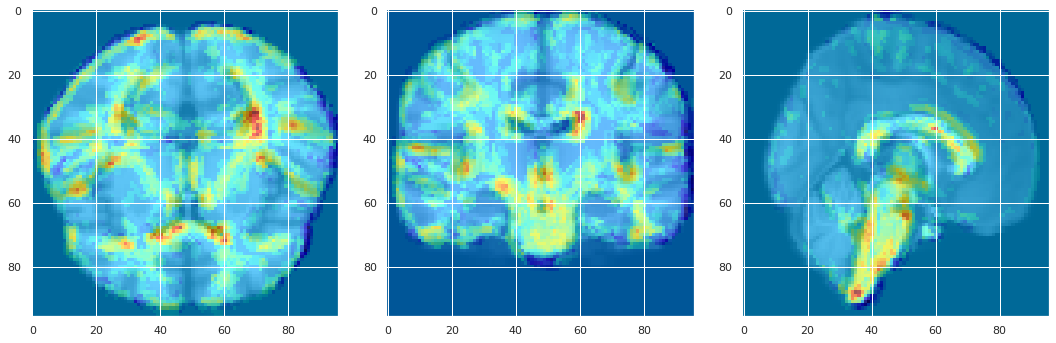

In [18]:
best_maps_naive = make_best_maps("naive")
best_maps_naive_threshold = \
    make_soft_thresholded_map(best_maps_naive, quantile)

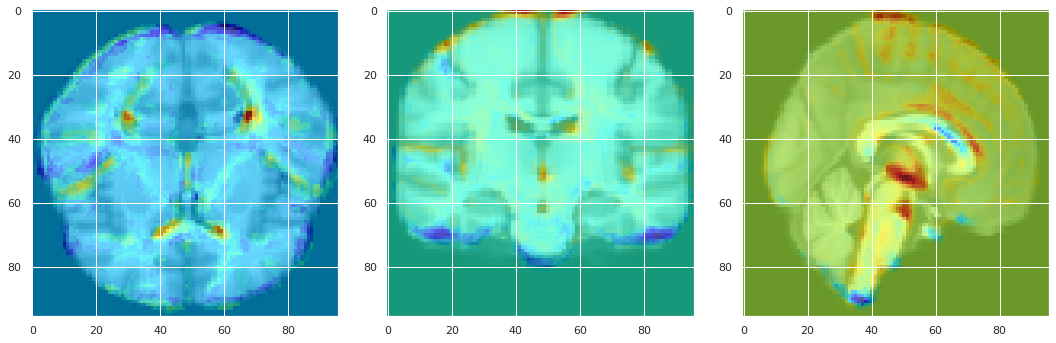

In [19]:
best_maps_augment = make_best_maps("augment")
best_maps_augment_threshold = \
    make_soft_thresholded_map(best_maps_augment, quantile)

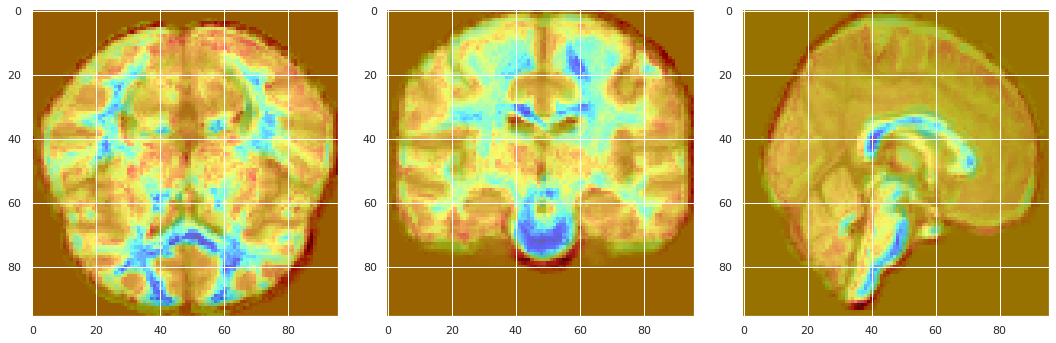

In [82]:
best_maps_naive_nonreg = make_best_maps("naive_nonreg")
best_maps_naive_nonreg_threshold = \
    make_soft_thresholded_map(best_maps_naive_nonreg, quantile)

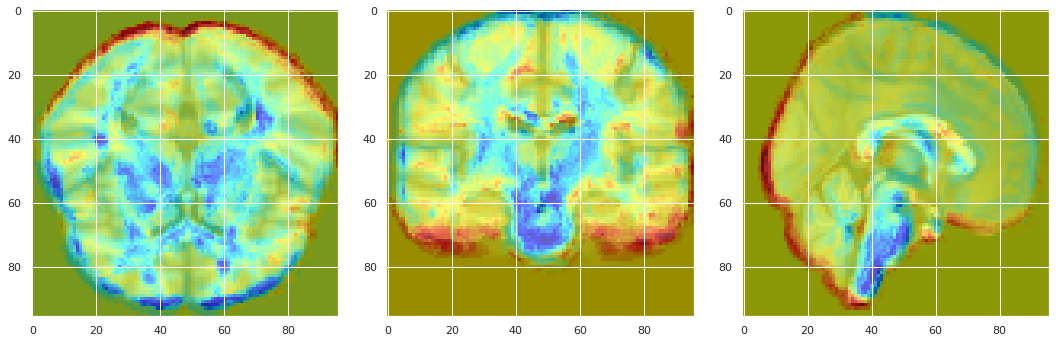

In [83]:
best_maps_augment_nonreg = make_best_maps("augment_nonreg")
best_maps_augment_nonreg_threshold = \
    make_soft_thresholded_map(best_maps_augment_nonreg, quantile)

In [84]:
# np.save(f"../new_result/naive_raw_top{top}.npy", best_maps_naive_threshold)
# np.save(f"../new_result/aug_raw_top{top}.npy", best_maps_augment_threshold)

# np.save(f"../new_result/naive_nonreg_raw_top{top}.npy", best_maps_naive_nonreg_threshold)
# np.save(f"../new_result/aug_nonreg_raw_top{top}.npy", best_maps_augment_nonreg_threshold)

In [86]:
# save2nifti(best_maps_naive_threshold, "../new_result/naive_raw_top10.nii")
# save2nifti(best_maps_augment_threshold, "../new_result/aug_raw_top10.nii")

save2nifti(best_maps_naive_nonreg_threshold, f"../miccai2022/test_newmethod/naive_nonreg_raw_top{top}.nii")
save2nifti(best_maps_augment_nonreg_threshold, f"../miccai2022/test_newmethod/aug_nonreg_raw_top{top}.nii")

Came across with array dimension of 4, (100, 96, 96, 96).
Shrink with average on axis=0
Successfully saved.
Came across with array dimension of 4, (100, 96, 96, 96).
Shrink with average on axis=0
Successfully saved.


## Random Sampling not Best Test MAE

In [ ]:
print("Random Naive")
for idx in range(10):

    random_maps_naive = make_random_maps("naive")
    random_maps_naive_threshold = \
        make_soft_thresholded_map(random_maps_naive, quantile)

    save2nifti(
        random_maps_naive_threshold,
        f"../miccai2022/random_sampling/naive_soft_top{top}_{str(idx).zfill(2)}.nii"
    )

In [ ]:
print("Random Augment")
for idx in range(10):

    random_maps_augment = make_random_maps("augment")
    random_maps_augment_threshold = \
        make_soft_thresholded_map(random_maps_augment, quantile)

    save2nifti(
        random_maps_augment_threshold,
        f"../miccai2022/random_sampling/aug_soft_top{top}_{str(idx).zfill(2)}.nii"
    )

## Early stopped epoch

In [14]:
def make_early_maps(config):

    """
    config <str>:
        use one of naive, naive_nonreg, augment, augment_nonreg
    """

    random_indices = {
    "naive": [e - 20 for e in total_train_naive],
    "augment": [e - 20 for e in total_train_augment],
    "naive_nonreg": [e - 20 for e in total_train_naive_nonreg],
    "augment_nonreg": [e - 20 for e in total_train_augment_nonreg],
    }

    selector = FileSelector(config)
    _cherry_picker = partial(cherry_picker, selector=selector)
    _check_existence = partial(check_existence, selector=selector)

    filtered = list(filter(
        _check_existence,
        zip(range(len(random_indices[config])), random_indices[config])
    ))
    stopped_map = np.array(list(map(
        _cherry_picker,
        filtered
    )))
    return stopped_map

def make_percentage_maps(config, pct):

    """
    config <str>:
        use one of naive, naive_nonreg, augment, augment_nonreg
    """

    random_indices = {
    "naive": [min(round(e * pct), e-1) for e in total_train_naive],
    "augment": [min(round(e * pct), e-1) for e in total_train_augment],
    "naive_nonreg": [min(round(e * pct), e-1) for e in total_train_naive_nonreg],
    "augment_nonreg": [min(round(e * pct), e-1) for e in total_train_augment_nonreg],
    }

    selector = FileSelector(config)
    _cherry_picker = partial(cherry_picker, selector=selector)
    _check_existence = partial(check_existence, selector=selector)

    filtered = list(filter(
        _check_existence,
        zip(range(len(random_indices[config])), random_indices[config])
    ))
    stopped_map = np.array(list(map(
        _cherry_picker,
        filtered
    )))
    return stopped_map

def make_epoch_maps(config, epoch):

    """
    config <str>:
        use one of naive, naive_nonreg, augment, augment_nonreg
    """

    random_indices = {
    "naive": [epoch for _ in total_train_naive],
    "augment": [epoch for _ in total_train_augment],
    "naive_nonreg": [epoch for _ in total_train_naive_nonreg],
    "augment_nonreg": [epoch for _ in total_train_augment_nonreg],
    }

    selector = FileSelector(config)
    _cherry_picker = partial(cherry_picker, selector=selector)
    _check_existence = partial(check_existence, selector=selector)

    filtered = list(filter(
        _check_existence,
        zip(range(len(random_indices[config])), random_indices[config])
    ))
    stopped_map = np.array(list(map(
        _cherry_picker,
        filtered
    )))
    return stopped_map

In [47]:
quantile = .90
top = round((1- quantile) * 100)
agree_threshold = 50

In [44]:
# print("Naive Earlystopped Checkpoints")
# stopped_maps_naive = make_early_maps("naive")
# stopped_maps_naive_threshold = \
#     make_soft_thresholded_map(stopped_maps_naive, quantile)
# naive_tmp = exp_quantile_agree(stopped_maps_naive_threshold, quantile, agree_threshold);

Naive Percentage Checkpoints
0.0


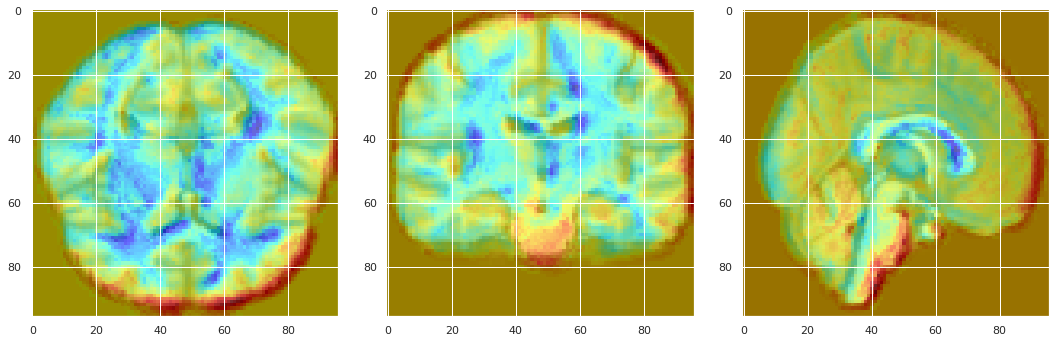

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 241


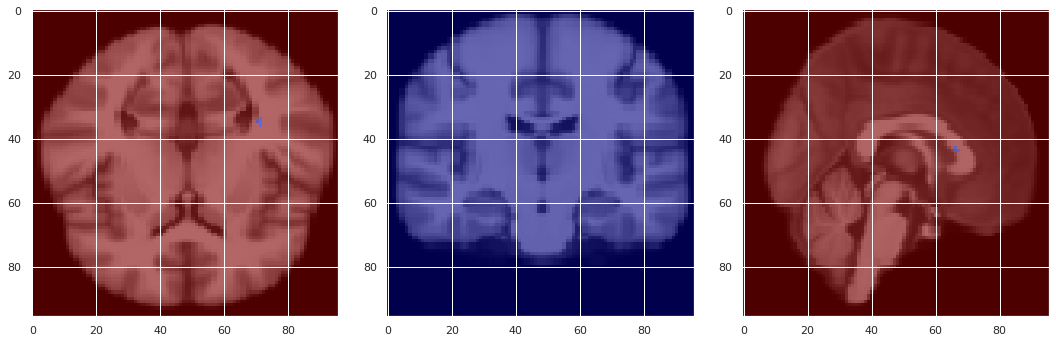

10.0


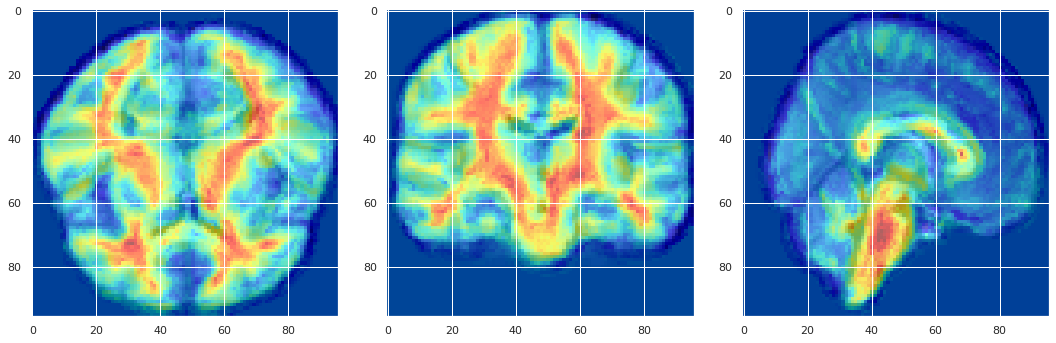

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 106


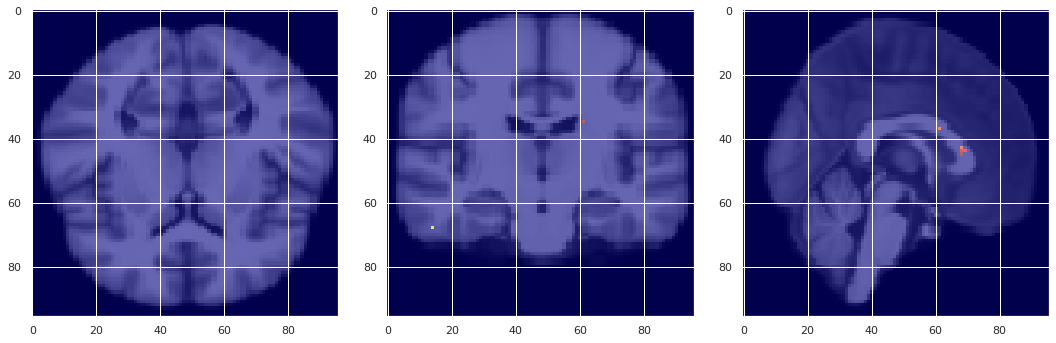

20.0


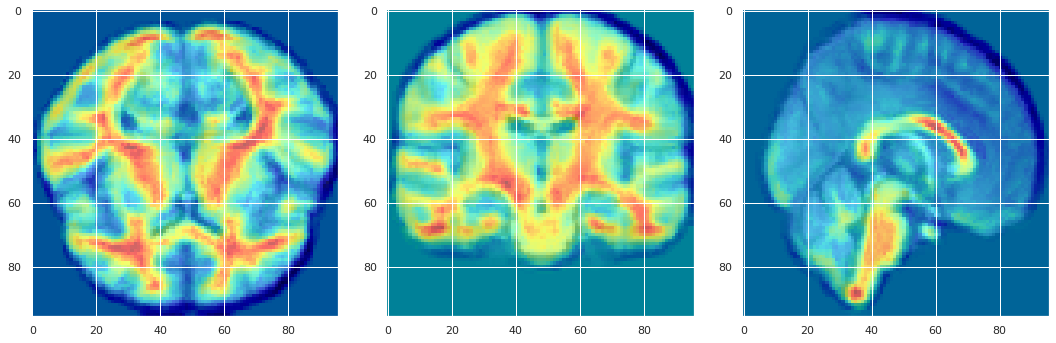

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 2492


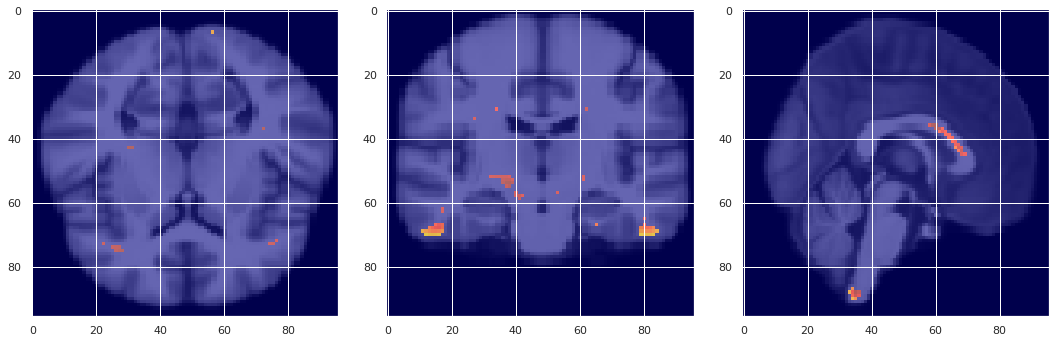

30.0


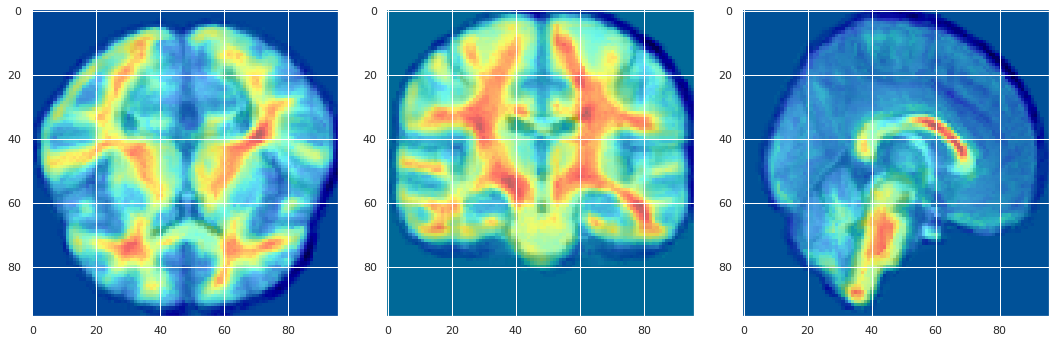

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 6993


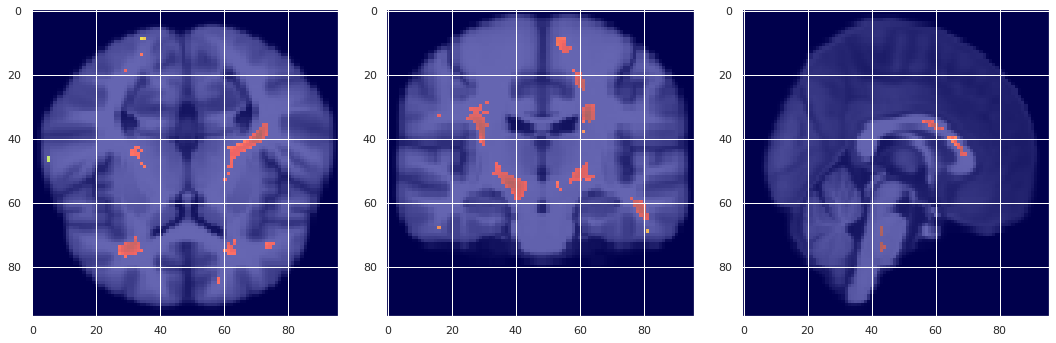

40.0


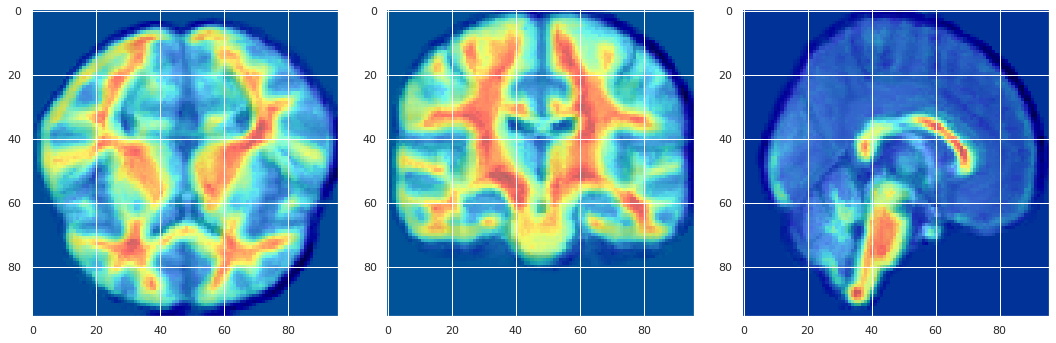

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 12803


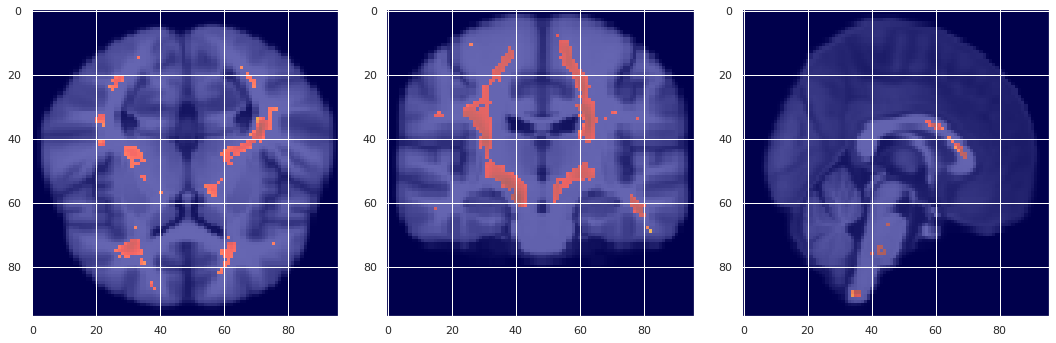

50.0


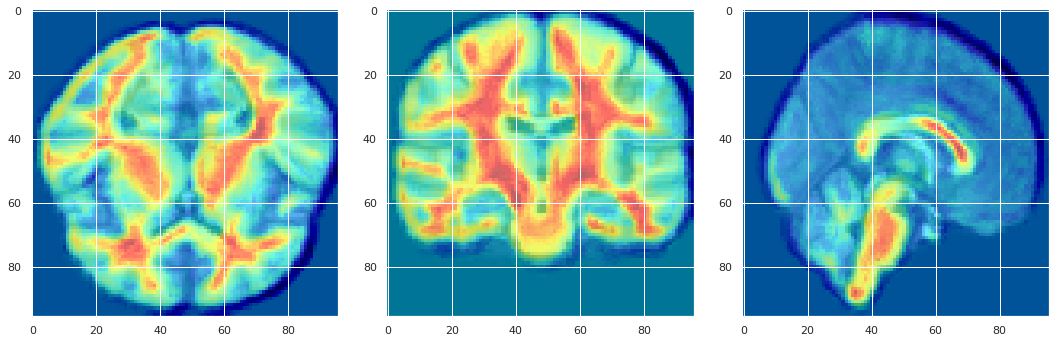

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 3444


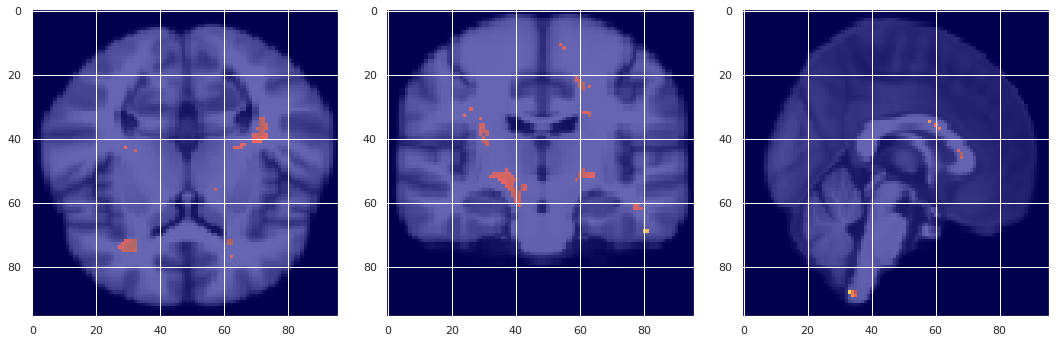

60.0


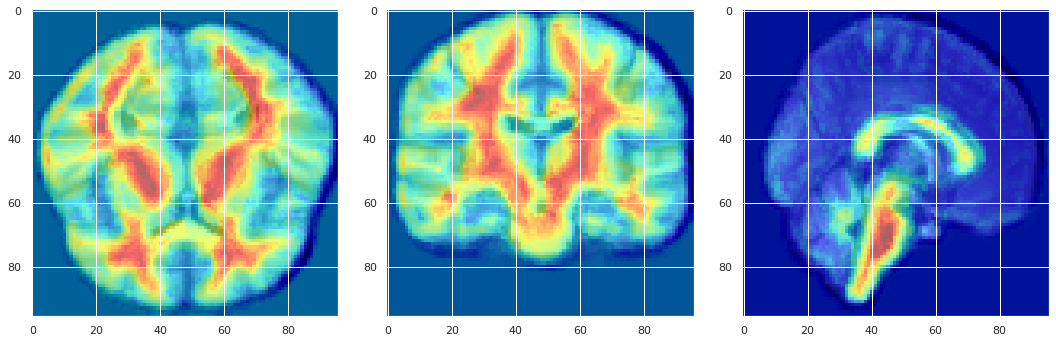

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 9965


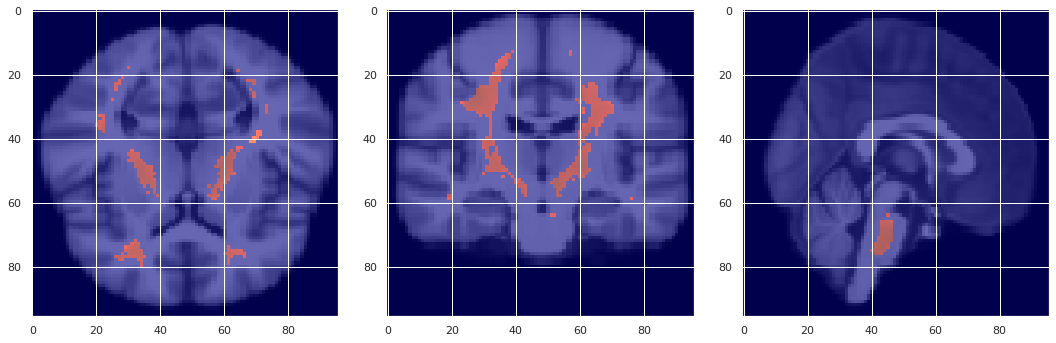

70.0


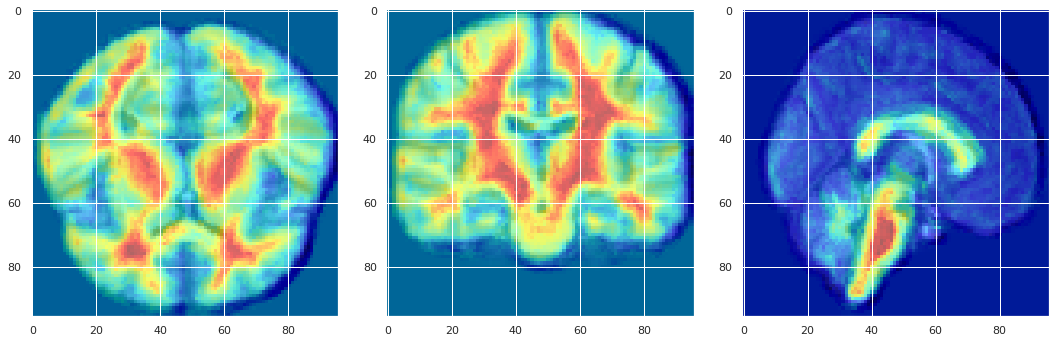

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 1092


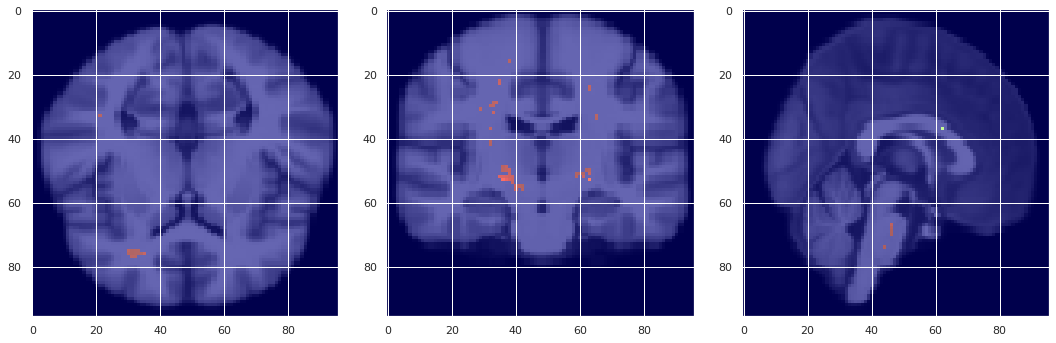

80.0


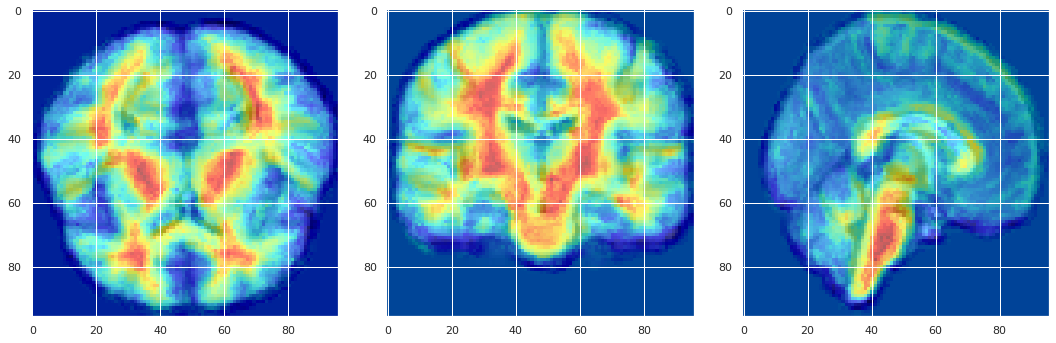

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 4


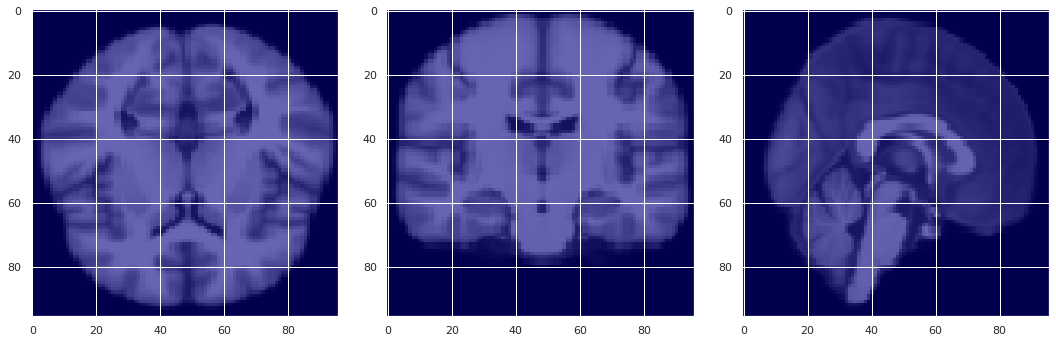

90.0


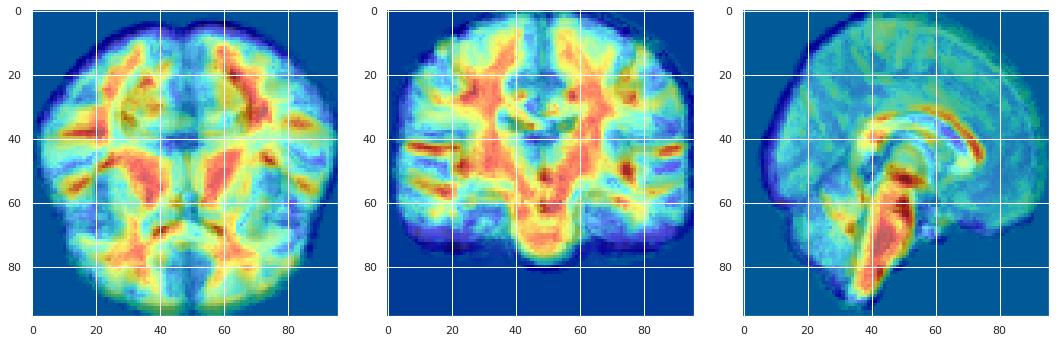

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 39


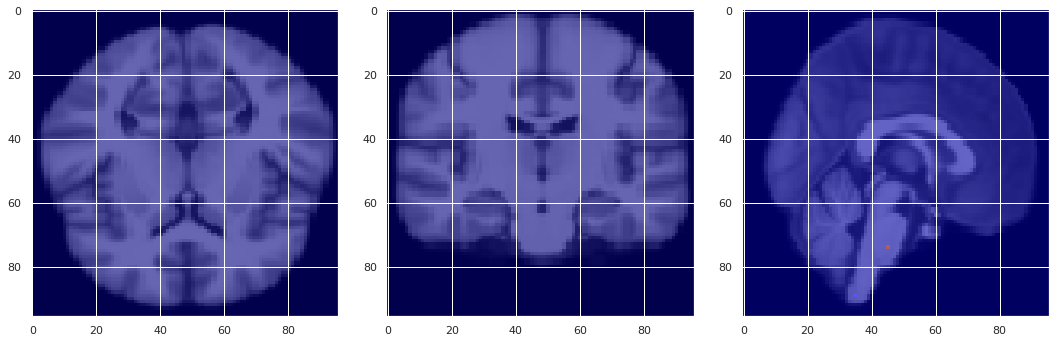

100.0


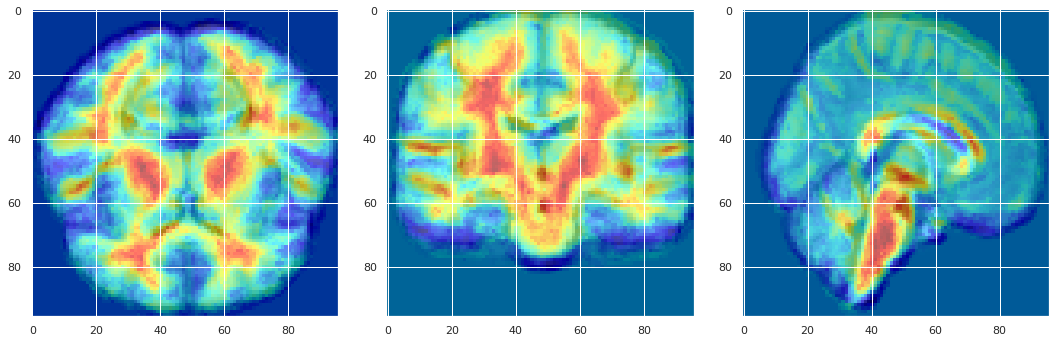

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 151


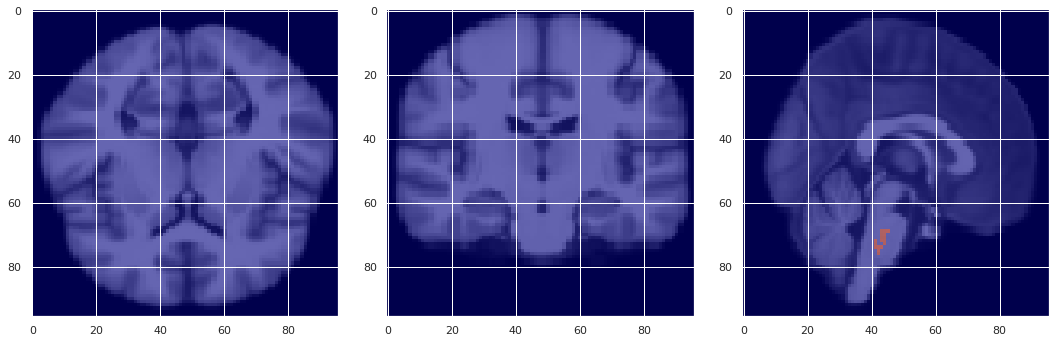

In [57]:
print("Naive Percentage Checkpoints")
for pct in [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

    p = str(int(pct * 100)).zfill(3)
    print(pct * 100)
    stopped_maps_naive = make_percentage_maps("naive", pct)
    stopped_maps_naive_threshold = \
        make_soft_thresholded_map(stopped_maps_naive, quantile)
    naive_tmp = exp_quantile_agree(stopped_maps_naive, quantile, agree_threshold);

    # save2nifti(stopped_maps_naive_threshold, f"../miccai2022/evolve/top{top}/naive/naive_{p}.nii")
    # save2nifti(naive_tmp, f"../miccai2022/evolve/top{top}_agree{agree_threshold}/naive/naive_{p}")

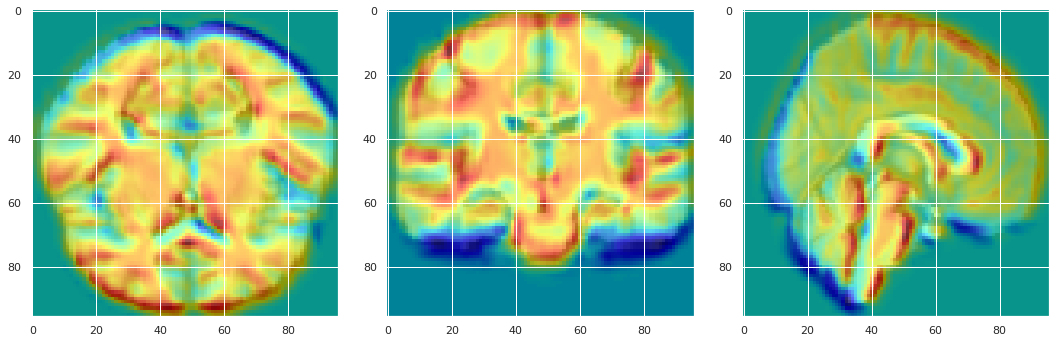

In [64]:
plot_vismap(AVG, stopped_maps_augment, masked=False);

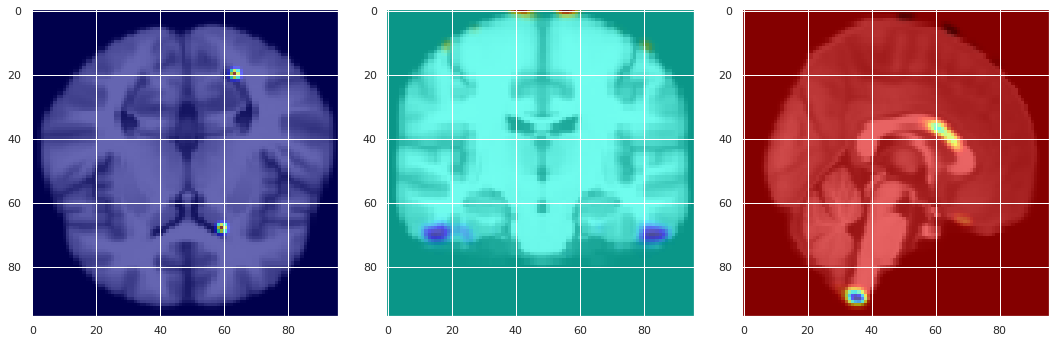

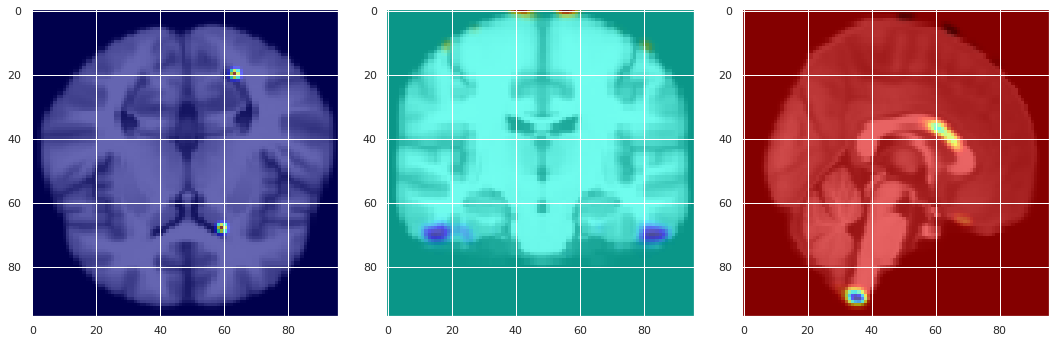

In [66]:
from skimage.filters import gaussian

plot_vismap(AVG, gaussian(augment_tmp), masked=False)

Augmentation Percentage Checkpoints
0.0


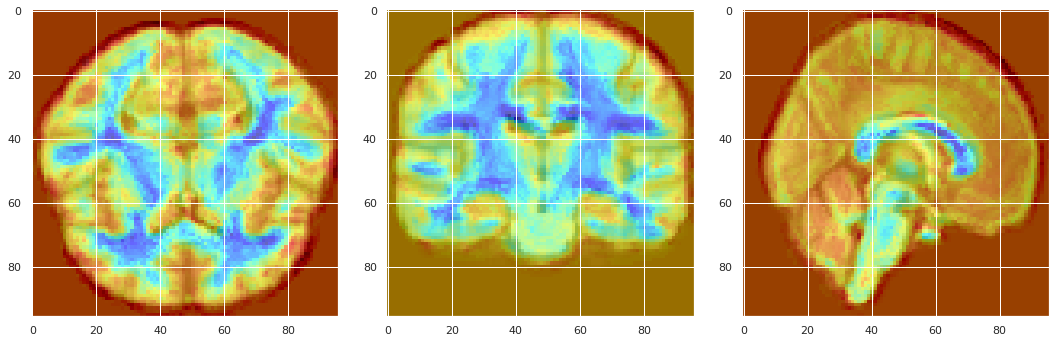

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 7027


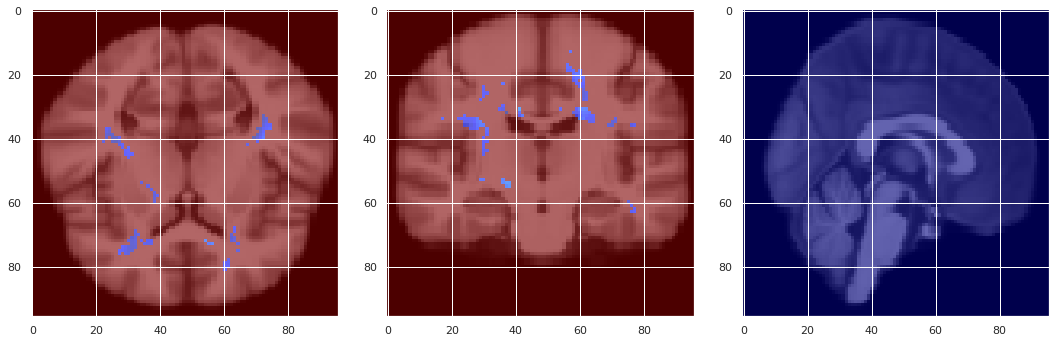

10.0


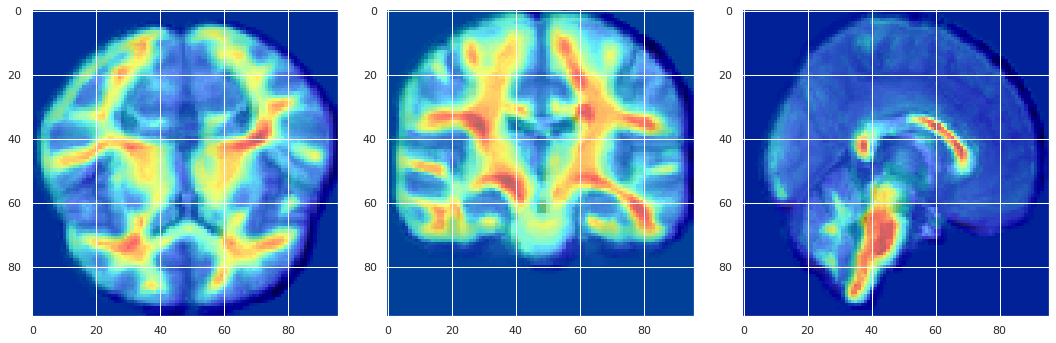

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 26543


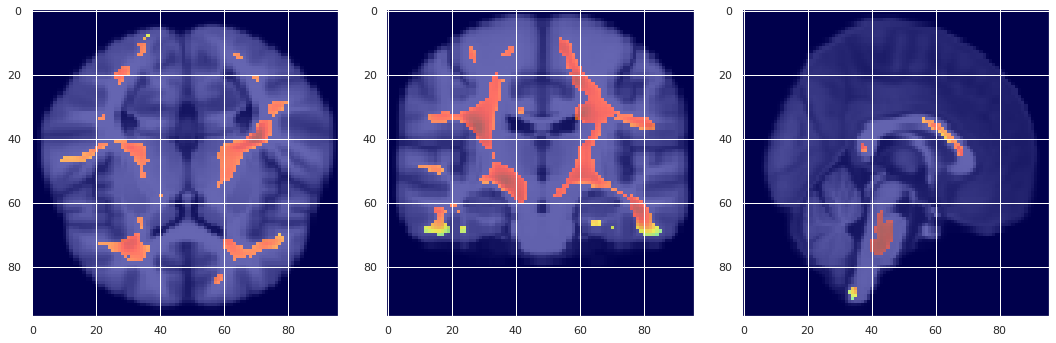

20.0


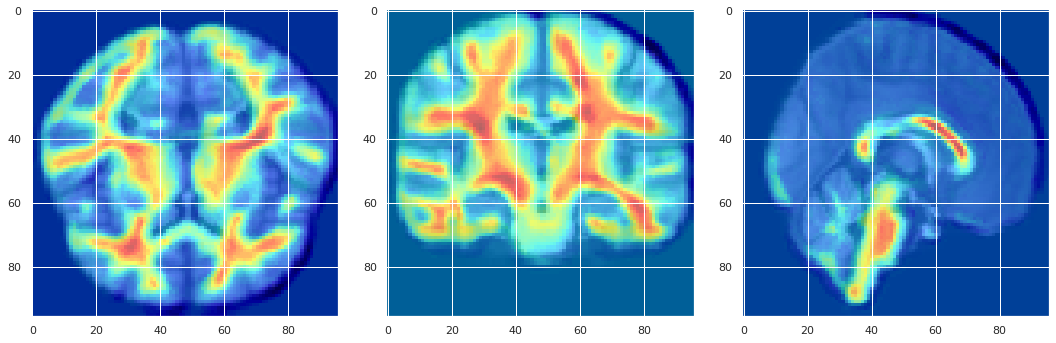

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 48145


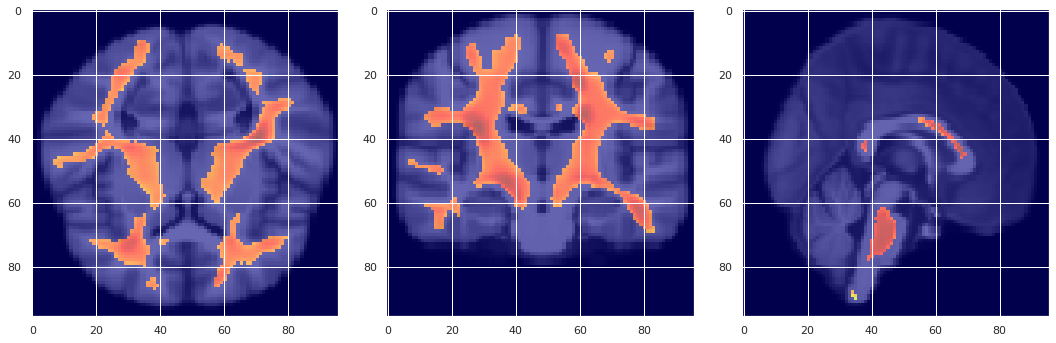

30.0


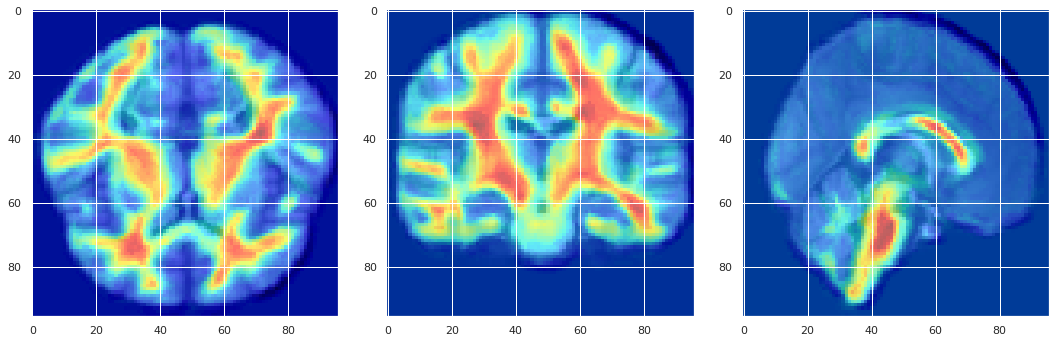

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 42194


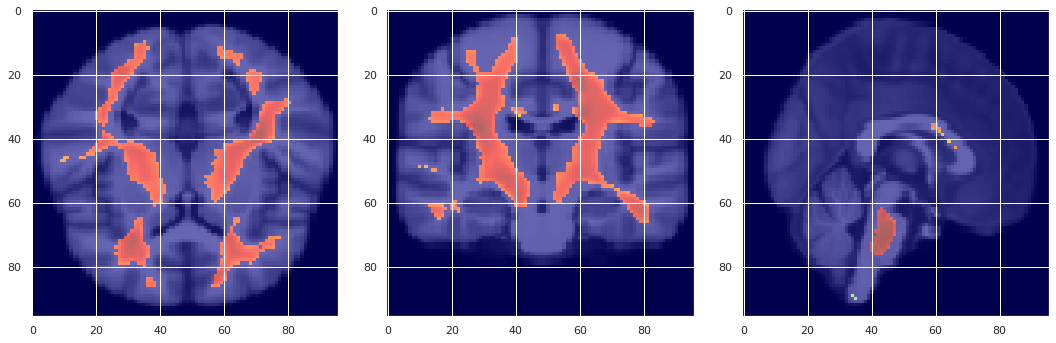

40.0


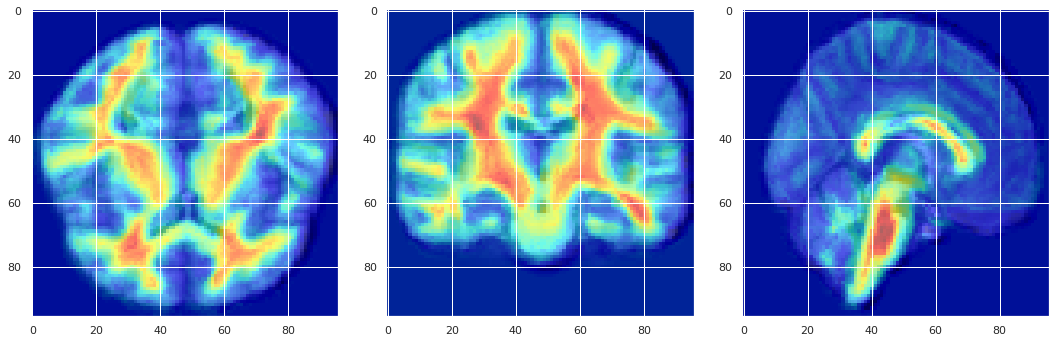

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 22027


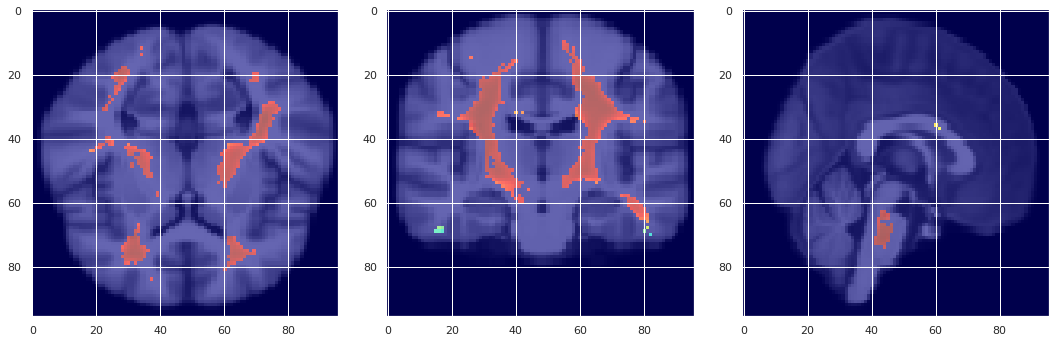

50.0


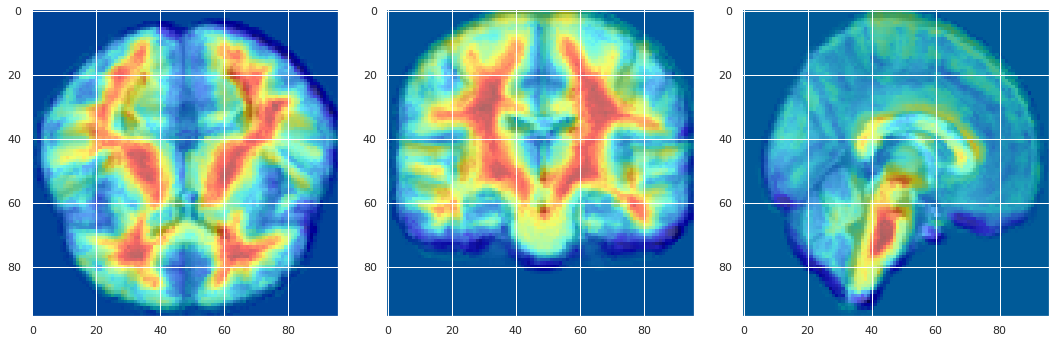

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 2150


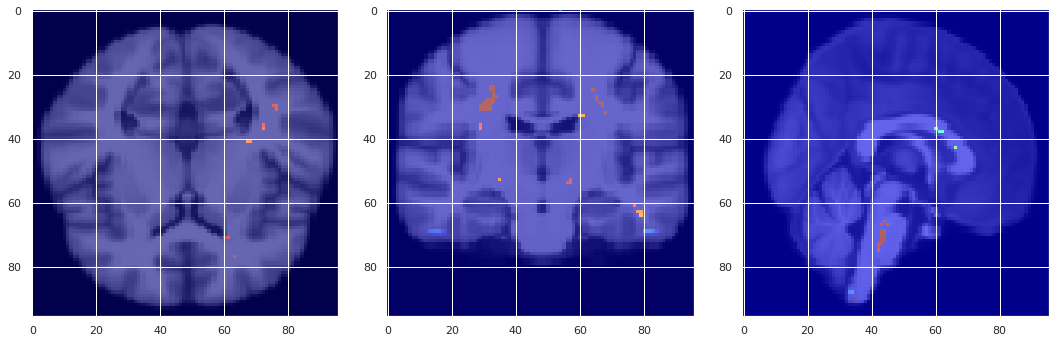

60.0


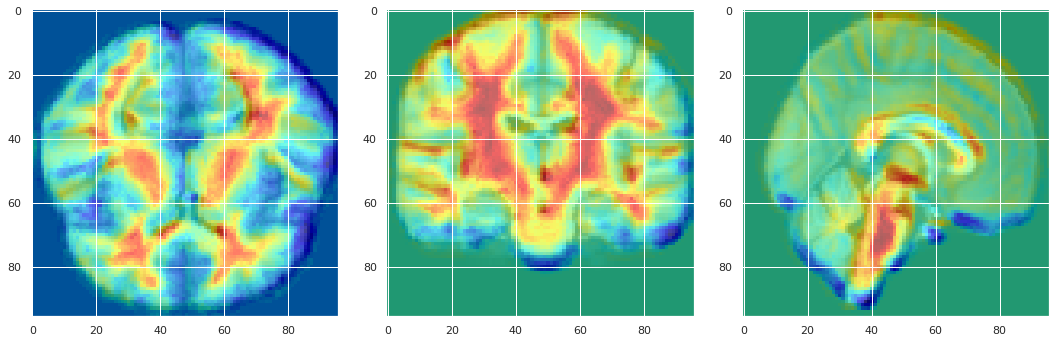

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 603


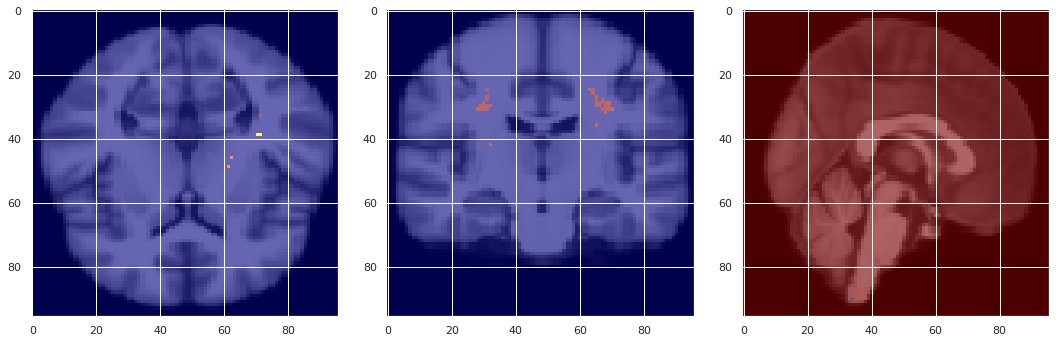

70.0


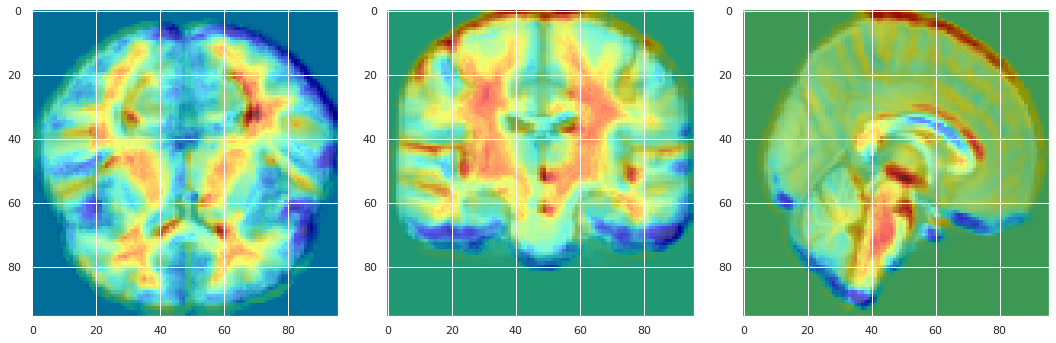

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 486


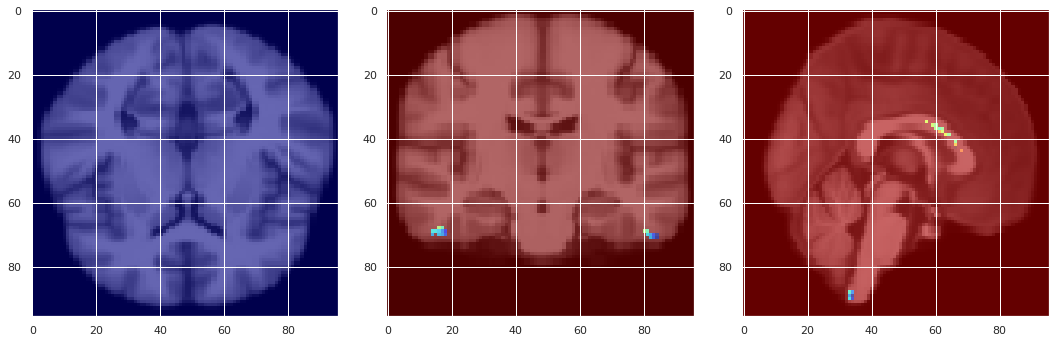

80.0


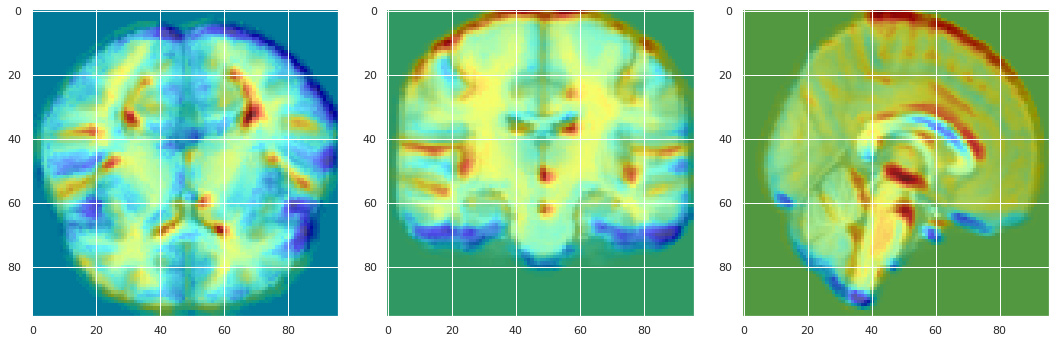

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 6092


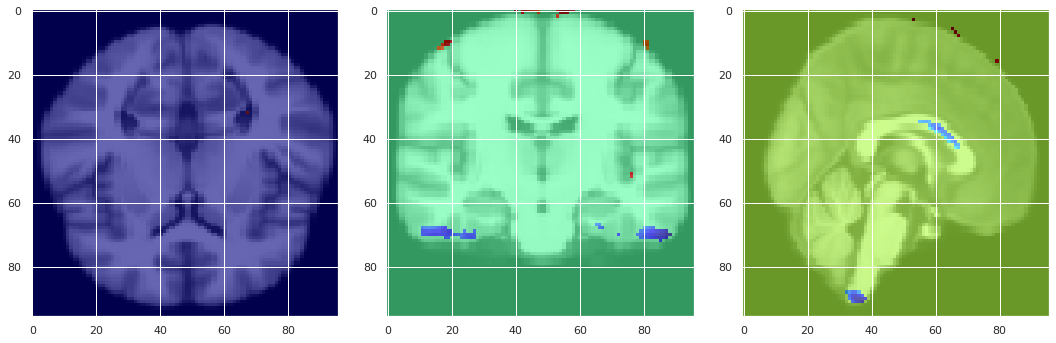

90.0


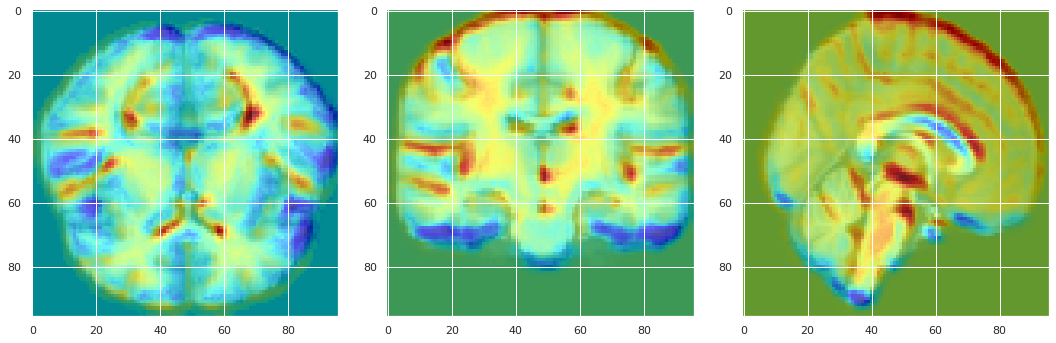

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 1135


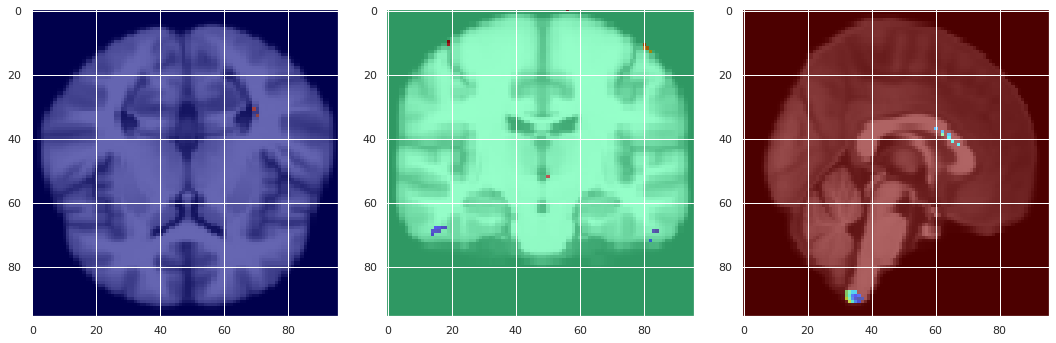

100.0


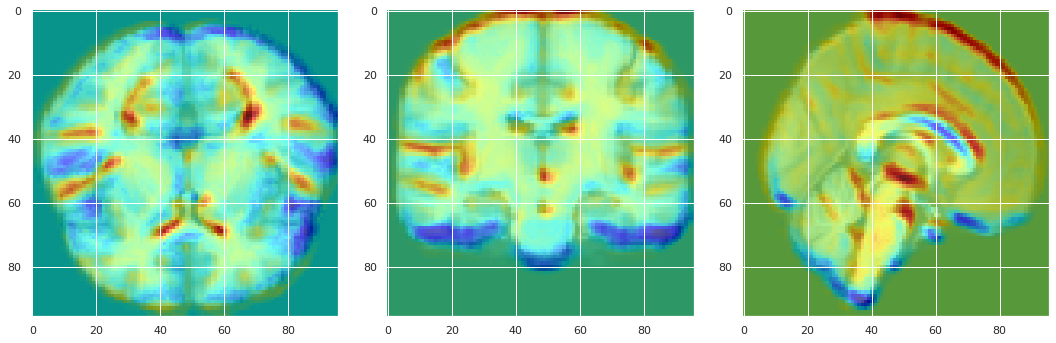

Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 3209


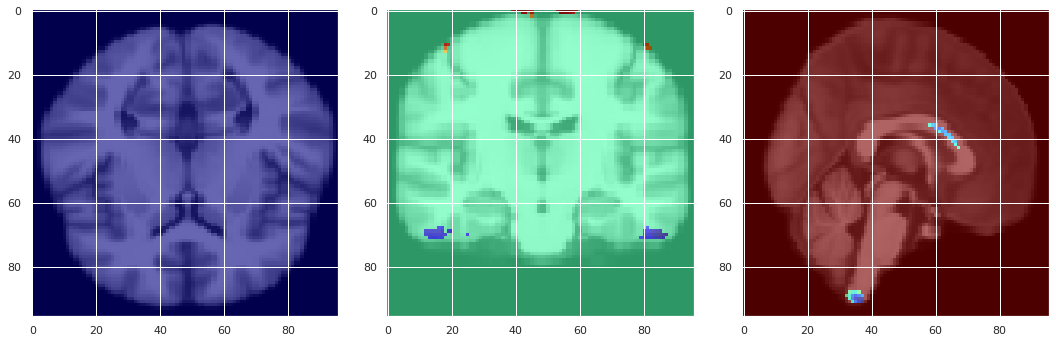

In [58]:
print("Augmentation Percentage Checkpoints")
for pct in [0., 0.1, 0.2, .3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

    p = str(int(pct * 100)).zfill(3)
    print(pct * 100)
    stopped_maps_augment = make_percentage_maps("augment", pct)
    stopped_maps_augment_threshold = \
        make_soft_thresholded_map(stopped_maps_augment, quantile)
    augment_tmp = exp_quantile_agree(stopped_maps_augment, quantile, agree_threshold);

    # save2nifti(stopped_maps_augment_threshold, f"../miccai2022/evolve/top{top}/augment/augment_{p}.nii")
    # save2nifti(augment_tmp, f"../miccai2022/evolve/top{top}_agree{agree_threshold}/augment/augment_{p}")

In [ ]:
intersection = ((naive_tmp != 0) & (augment_tmp != 0)).astype(np.float32)
print(f"Nonzero Voxels: {count_nonzero_voxels(intersection)}")
plot_vismap(AVG, intersection, masked=True);

### Top n% with m-agreements + random

In [24]:
quantile = .90
top = int(1-quantile)

agree_threshold = 45

In [ ]:
print("Random Naive")
for idx in range(10):

    random_maps_naive = make_random_maps("naive")
    random_maps_naive_threshold = \
        make_soft_thresholded_map(random_maps_naive, quantile, plot=False)

    naive_tmp = exp_quantile_agree(random_maps_naive_threshold, quantile, agree_threshold);

In [ ]:
print("Random Augment")
for idx in range(10):

    random_maps_augment = make_random_maps("augment")
    random_maps_augment_threshold = \
        make_soft_thresholded_map(random_maps_augment, quantile, plot=False)

    aug_tmp = exp_quantile_agree(random_maps_augment_threshold, quantile, agree_threshold);

### Top n% with m-agreements between seeds

In [26]:
quantile = .90
top = int(1-quantile)

agree_threshold = 45

In [ ]:
print("Naive")
naive_tmp = exp_quantile_agree(best_maps_naive, quantile, agree_threshold);
print("Augment")
aug_tmp = exp_quantile_agree(best_maps_augment, quantile, agree_threshold);

In [ ]:
intersection = ((naive_tmp != 0) & (aug_tmp != 0)).astype(np.float32)
print(f"Nonzero Voxels: {count_nonzero_voxels(intersection)}")
plot_vismap(AVG, intersection, masked=True);

In [68]:
# top = round((1 - quantile)*100)
# config = f"top{top}_agree{agree_threshold}"
# dir_name = f"../miccai2022/{config}_best"
# print(dir_name)
# os.mkdir(dir_name)
# save2nifti(naive_tmp, Path(dir_name, f"{config}_naive.nii"))
# save2nifti(aug_tmp, Path(dir_name, f"{config}_augment.nii"))
# save2nifti(intersection, Path(dir_name, f"{config}_intersect.nii"))

In [ ]:
print("Naive Non-registered")
naive_nonreg_tmp = exp_quantile_agree(best_maps_naive_nonreg, quantile, agree_threshold);
print("Augment Non-registered")
aug_nonreg_tmp = exp_quantile_agree(best_maps_augment_nonreg, quantile, agree_threshold);

In [ ]:
intersection_nonreg = ((naive_nonreg_tmp != 0) & (aug_nonreg_tmp != 0)).astype(np.float32)
print(f"Nonzero Voxels: {count_nonzero_voxels(intersection_nonreg)}")
plot_vismap(AVG, intersection_nonreg, masked=True);

## Misc

1. Plot non-zero values historgram
2. Plot non-zero values among agreement threshold

In [77]:
non_zero = lambda x: list(filter(lambda a: a != 0, x.flatten()))

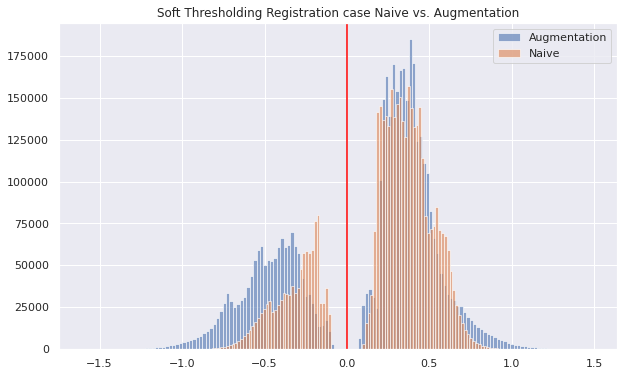

In [78]:
plt.figure(figsize=(10, 6));
plt.title("Soft Thresholding Registration case Naive vs. Augmentation")
plt.hist(non_zero(best_maps_augment_threshold), bins=150, label="Augmentation", alpha=.6);
plt.hist(non_zero(best_maps_naive_threshold), bins=150, label="Naive", alpha=.6);

plt.axvline(0, color="red");
plt.legend();

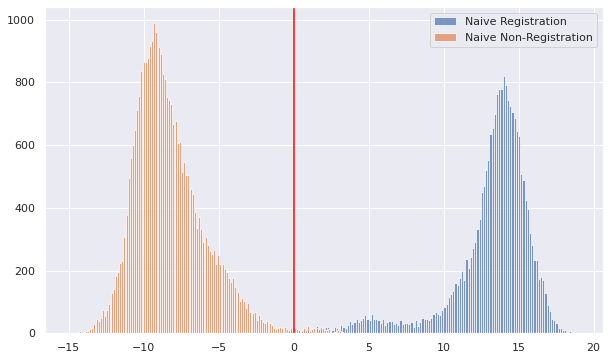

In [69]:
plt.figure(figsize=(10, 6));
plt.hist(non_zero(naive_tmp), bins=150, label="Naive Registration", alpha=.7);
plt.hist(non_zero(naive_nonreg_tmp), bins=150, label="Naive Non-Registration", alpha=.7);
plt.axvline(0, color="red");
plt.legend();

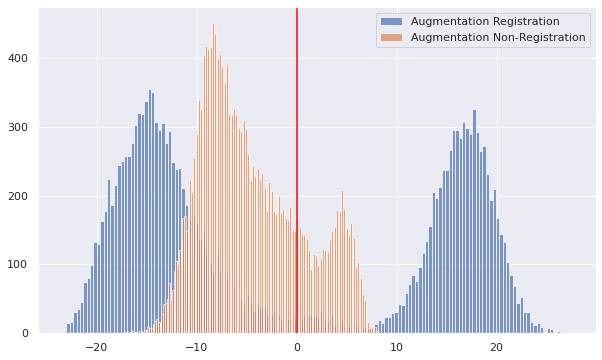

In [63]:
plt.figure(figsize=(10, 6));
plt.hist(non_zero(aug_tmp), bins=150, label="Augmentation Registration", alpha=.7);
plt.hist(non_zero(aug_nonreg_tmp), bins=150, label="Augmentation Non-Registration", alpha=.7);
plt.axvline(0, color="red");
plt.legend();

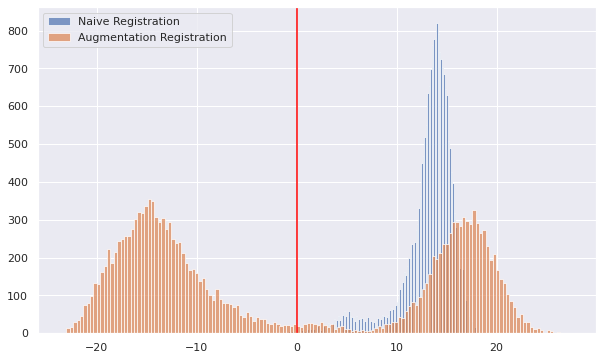

In [73]:
plt.figure(figsize=(10, 6));
plt.hist(non_zero(naive_tmp), bins=150, label="Naive Registration", alpha=.7);
plt.hist(non_zero(aug_tmp), bins=150, label="Augmentation Registration", alpha=.7);
plt.axvline(0, color="red");
plt.legend();

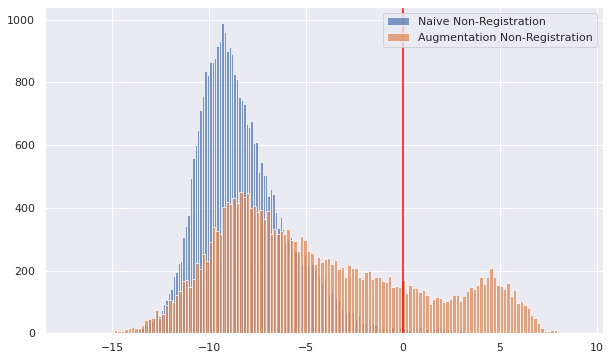

In [70]:
plt.figure(figsize=(10, 6));
plt.hist(non_zero(naive_nonreg_tmp), bins=150, label="Naive Non-Registration", alpha=.7);
plt.hist(non_zero(aug_nonreg_tmp), bins=150, label="Augmentation Non-Registration", alpha=.7);
plt.axvline(0, color="red");
plt.legend();

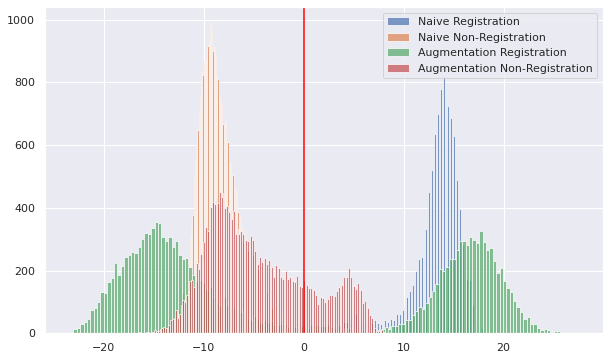

In [71]:
plt.figure(figsize=(10, 6));

plt.hist(non_zero(naive_tmp), bins=150, label="Naive Registration", alpha=.7);
plt.hist(non_zero(naive_nonreg_tmp), bins=150, label="Naive Non-Registration", alpha=.7);

plt.hist(non_zero(aug_tmp), bins=150, label="Augmentation Registration", alpha=.7);
plt.hist(non_zero(aug_nonreg_tmp), bins=150, label="Augmentation Non-Registration", alpha=.7);

plt.axvline(0, color="red");

plt.legend();

In [ ]:
naive_nonzero = []
aug_nonzero = []
intersection_nonzero = []

for _agree_threshold in range(100):
    
    naive_tmp = exp_quantile_agree(best_maps_naive, quantile, _agree_threshold, plot=False)
    aug_tmp = exp_quantile_agree(best_maps_augment, quantile, _agree_threshold, plot=False)
    naive_nonzero.append(count_nonzero_voxels(naive_tmp))
    aug_nonzero.append(count_nonzero_voxels(aug_tmp))

    intersection = ((naive_tmp != 0) & (aug_tmp != 0)).astype(np.float32)
    intersection_nonzero.append(count_nonzero_voxels(intersection))

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_title(f"Non zero Voxels for top{round(100 * (1-quantile))}%", size="x-large")
ax.plot(naive_nonzero, label="Naive")
ax.plot(aug_nonzero, label="Augmentation")
ax.plot(intersection_nonzero, label="Intersection")
# ax.set_xlim(30, 60)
# ax.set_ylim(0, 1000)
ax.legend()

## Augmentation Ablation

In [3]:
aug_results = sorted(glob("../augment_ablation/*"))

In [4]:
aug_min = {}
for idx, _result in enumerate(aug_results):

    with open(_result + "/test.yml", "r") as f:
        test_prediction = yaml.load(f, Loader=yaml.Loader)

    test_maes = [MAE(gt_result, _prediction) for _prediction in test_prediction.values()]
    min_mae = min(test_maes)
    min_epoch = np.argmin(min_mae)
    
    aug_min[idx] = {
        "aug_proba": load_config(_result + "/config.yml").aug_proba,
        "min_mae": min_mae,
        "min_epoch": min_epoch,
        "test_maes": test_maes,
    }

    npy_list = sorted(glob(_result + "/npy_std/layer0/*.npy"))
    selected_npy = list(filter(lambda x: epoch_parser(x) == min_epoch, npy_list))
    assert len(selected_npy) == 1

    selected_npy = selected_npy[0]
    aug_min[idx].update({
        "npy": np.load(selected_npy),
        "npy_path": selected_npy
    })

In [ ]:
result_index = 1
npy_root = sorted(glob("../resnet256_augmentation_checkpoints/*"))[result_index]
npy_list = sorted(glob(npy_root + "/npy_std/layer0/*.npy"))
with open(npy_root + "/test.yml", "r") as f:
    test_prediction = yaml.load(f, Loader=yaml.Loader)
test_maes = [MAE(gt_result, _prediction) for _prediction in test_prediction.values()]

print(f"Total {len(test_maes)} runs.")
for idx, _npy_path in enumerate(npy_list):

    print(f"Epoch {idx} | Test MAE {test_maes[idx]}")
    plot_vismap(AVG, np.load(_npy_path), masked=False);

In [ ]:
result_index = 1
npy_root = sorted(glob("../resnet256_naive_checkpoints/*"))[result_index]
npy_list = sorted(glob(npy_root + "/npy_std/layer0/*.npy"))
with open(npy_root + "/test.yml", "r") as f:
    test_prediction = yaml.load(f, Loader=yaml.Loader)
test_maes = [MAE(gt_result, _prediction) for _prediction in test_prediction.values()]

print(f"Total {len(test_maes)} runs.")
for idx, _npy_path in enumerate(npy_list):

    print(f"Epoch {idx} | Test MAE {test_maes[idx]}")
    plot_vismap(AVG, np.load(_npy_path), masked=False);

In [ ]:
npy_root = sorted(glob("../resnet256_naive_checkpoints/*"))[23] + "/npy_std/layer0/*.npy"
npy_list = sorted(glob(npy_root))
for idx, _npy_path in enumerate(npy_list):

    print(f"Epoch {idx} | Test MAE {mae_parser(_npy_path)}")
    plot_vismap(AVG, np.load(_npy_path), masked=False);

Augmentation Probability: {'affine': 0.5, 'elastic_deform': 0.0, 'flip': 0.5}
../augment_ablation/20220219-2026_resnet/npy_std/layer0/ep000_mae51.65.npy


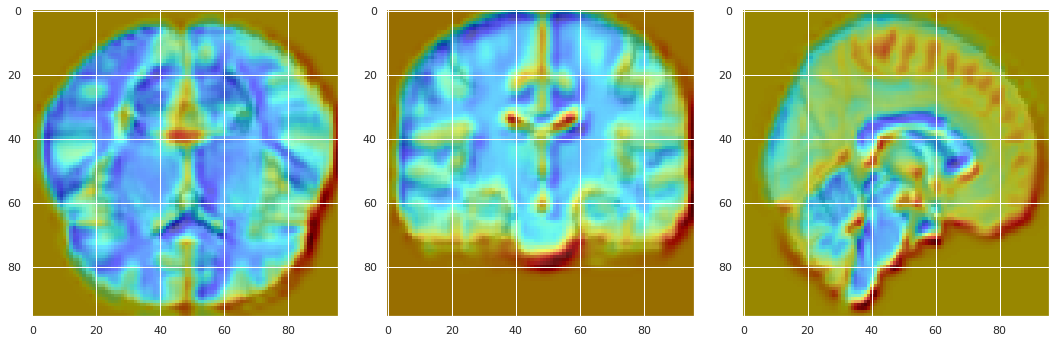

Augmentation Probability: {'affine': 0.0, 'elastic_deform': 0.5, 'flip': 0.5}
../augment_ablation/20220219-2124_resnet/npy_std/layer0/ep000_mae52.55.npy


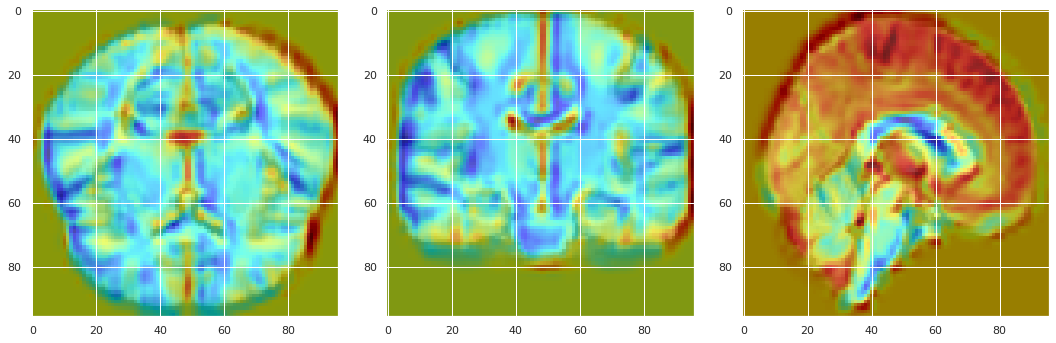

Augmentation Probability: {'affine': 0.5, 'elastic_deform': 0.5, 'flip': 0.0}
../augment_ablation/20220220-0110_resnet/npy_std/layer0/ep000_mae55.31.npy


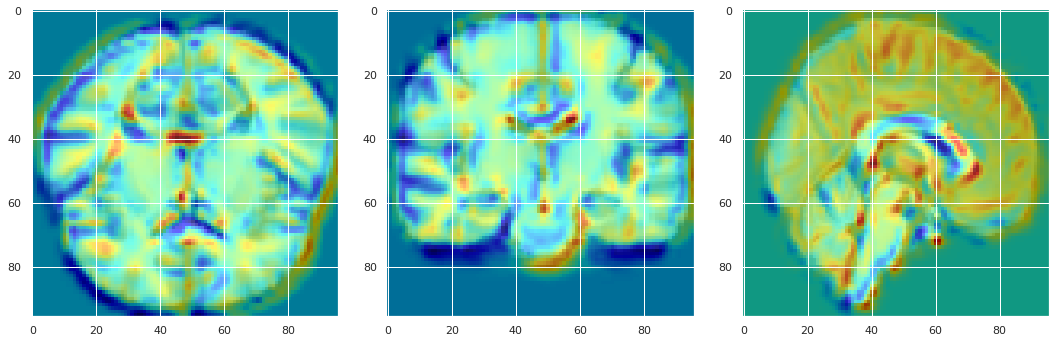

Augmentation Probability: {'affine': 1.0, 'elastic_deform': 0.0, 'flip': 0.0}
../augment_ablation/20220220-0354_resnet/npy_std/layer0/ep000_mae53.85.npy


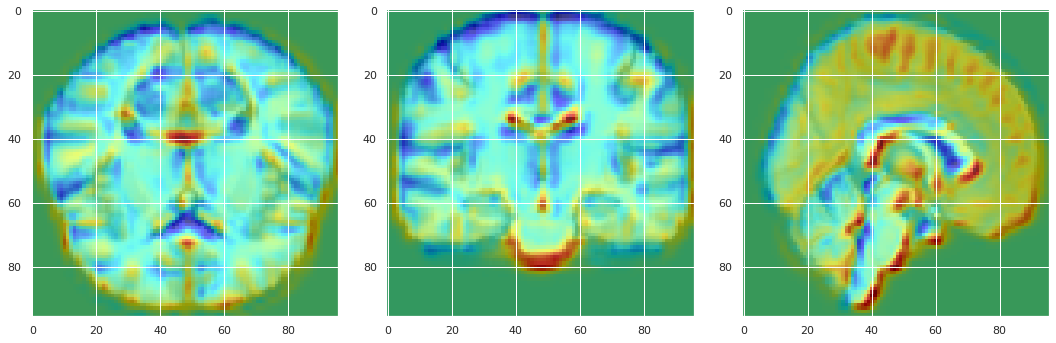

Augmentation Probability: {'affine': 0.0, 'elastic_deform': 0.0, 'flip': 1.0}
../augment_ablation/20220220-0434_resnet/npy_std/layer0/ep000_mae55.35.npy


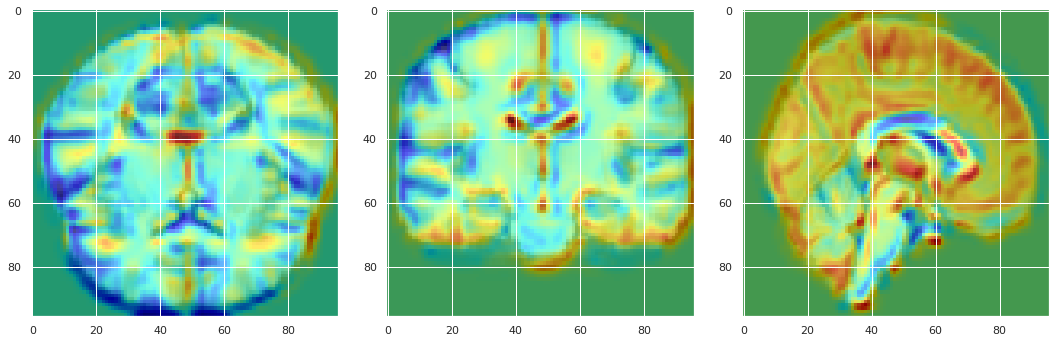

Augmentation Probability: {'affine': 0.0, 'elastic_deform': 1.0, 'flip': 0.0}
../augment_ablation/20220220-0456_resnet/npy_std/layer0/ep000_mae53.66.npy


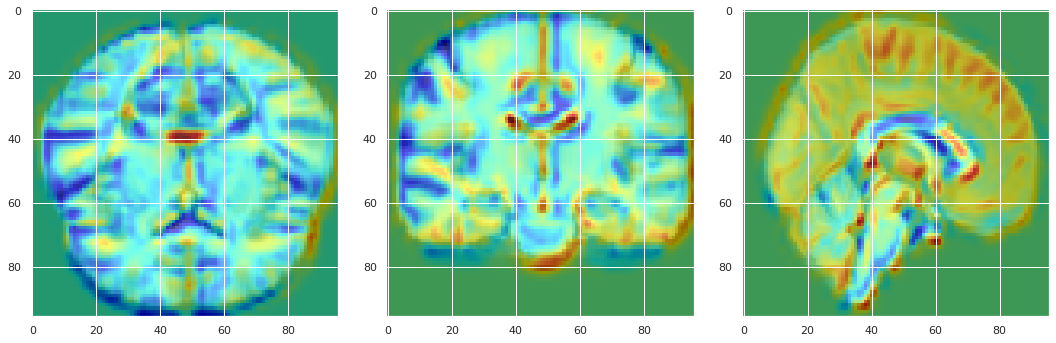

In [5]:
for idx, _dict in aug_min.items():

    print(f"Augmentation Probability: {_dict['aug_proba']}")
    print(f"{_dict['npy_path']}")
    plot_vismap(AVG, aug_min[idx]["npy"], masked=False);

In [19]:
def to_title(aug_proba: dict):

    title = ""
    for k, p in aug_proba.items():
        if p != 0:
            title += k
            title += str(int(p * 100))
            title += "_"
    return title

In [20]:
to_title(aug_min[0]["aug_proba"])

'affine50_flip50_'

Total 76 runs.


/tmp/ipykernel_4166664/1606544073.py:41: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


Total 76 runs.


/tmp/ipykernel_4166664/1606544073.py:41: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


Total 76 runs.


/tmp/ipykernel_4166664/1606544073.py:41: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


Total 76 runs.


/tmp/ipykernel_4166664/1606544073.py:41: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


Total 76 runs.


/tmp/ipykernel_4166664/1606544073.py:41: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


Total 76 runs.


/tmp/ipykernel_4166664/1606544073.py:41: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


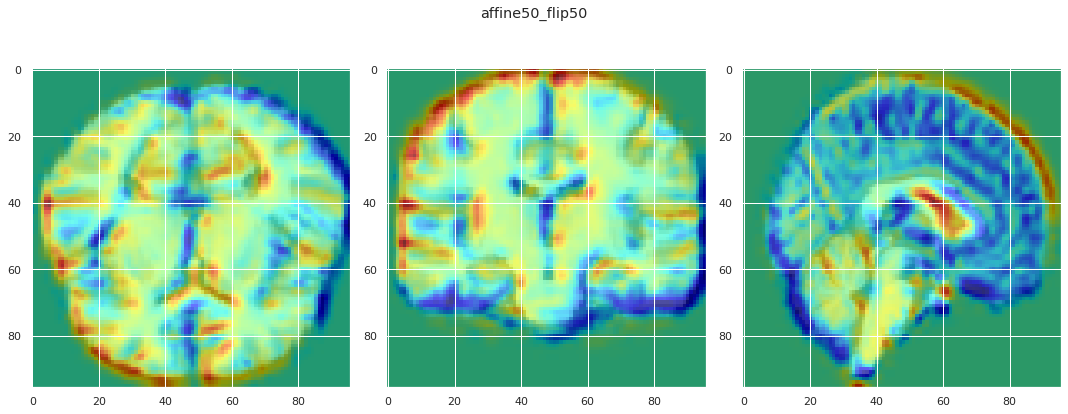

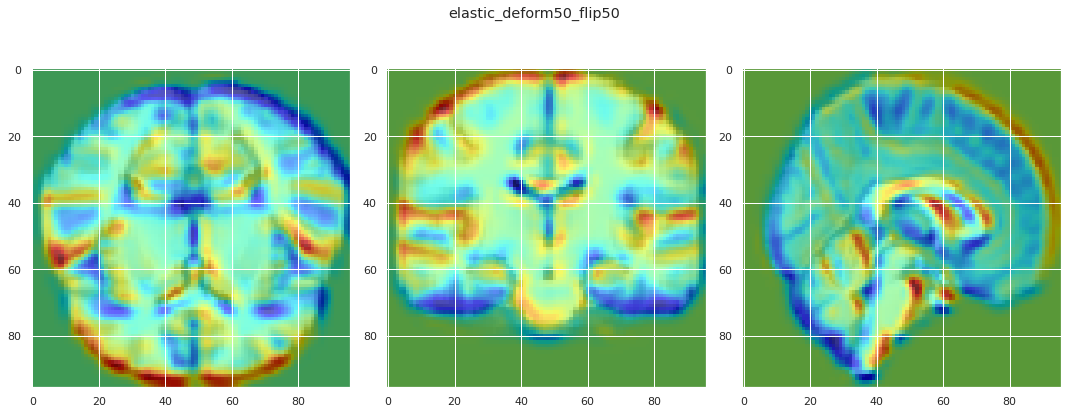

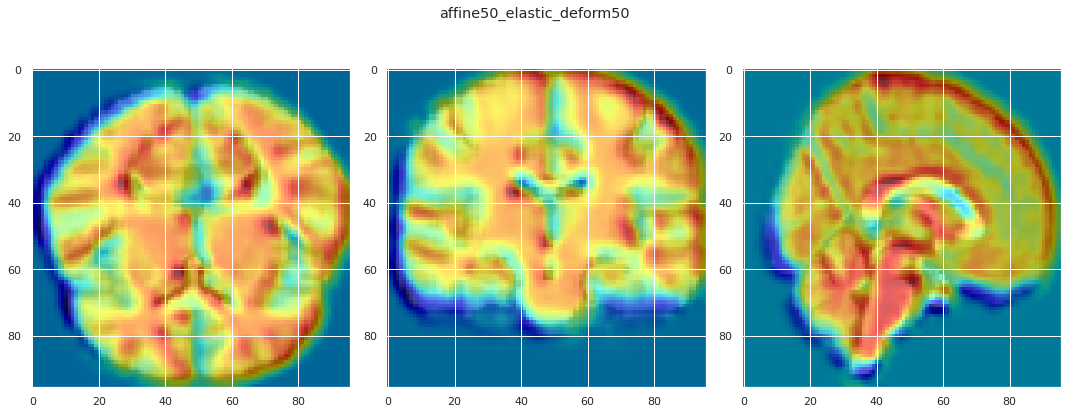

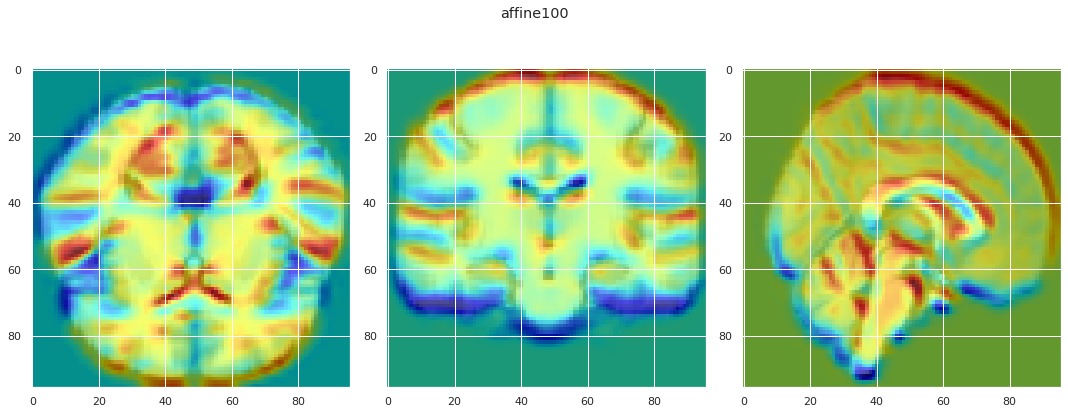

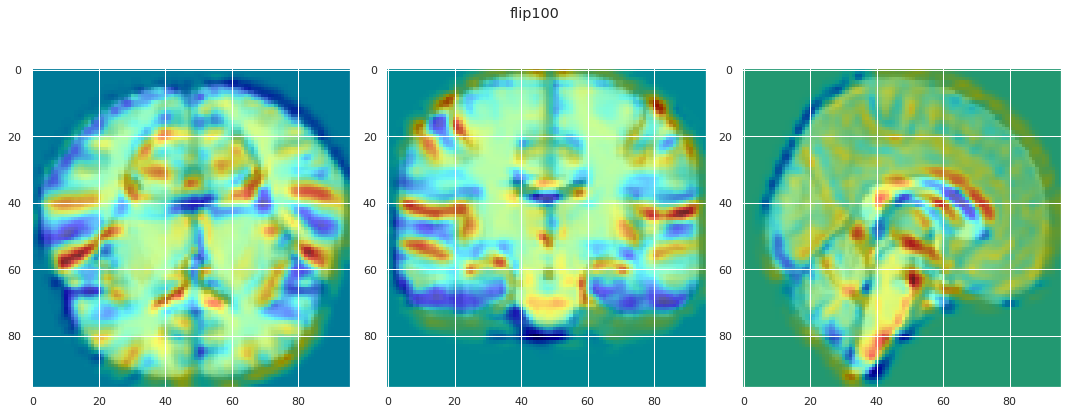

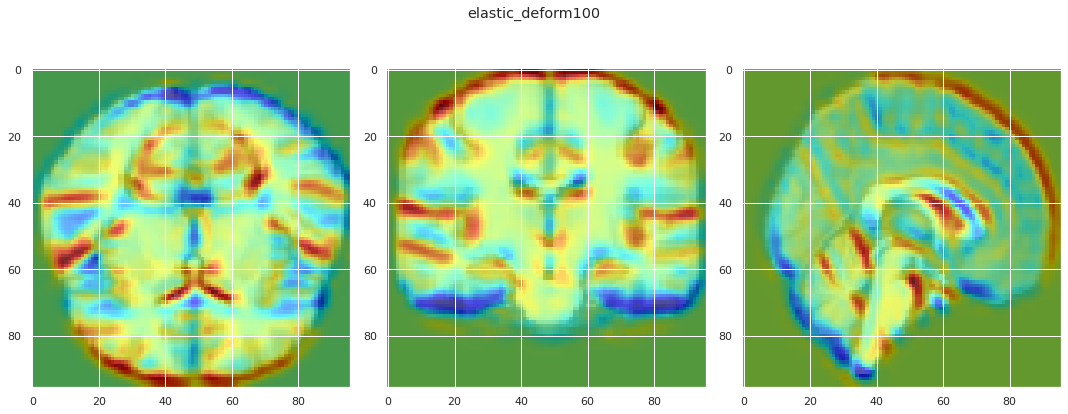

In [23]:
for _result in aug_results:

    npy_path = sorted(glob(_result + "/npy_std/layer0/*.npy"))
    aug_proba = load_config(_result + "/config.yml").aug_proba
    # print(f"../miccai2022/aug_ablation/{to_title(aug_proba)[:-1]}.mp4")
    make_mp4(npy_path, f"../miccai2022/aug_ablation/{to_title(aug_proba)[:-1]}.mp4")

In [116]:
# plot_vismap(AVG, (aug_min[0]["npy"] - aug_min[1]["npy"]), masked=False);
# plot_vismap(AVG, (aug_min[1]["npy"] - aug_min[2]["npy"]), masked=False);
# plot_vismap(AVG, (aug_min[2]["npy"] - aug_min[0]["npy"]), masked=False);

## Single Dataset Explainability Map

In [108]:
single_dataset_results = sorted(glob("../resnet256_datasetwise/*"))
single_min = {}
for idx, _result in enumerate(single_dataset_results):

    with open(_result + "/test.yml", "r") as f:
        test_prediction = yaml.load(f, Loader=yaml.Loader)
    config = load_config(_result + "/config.yml")
    trainer = MRITrainer(config)
    gt_result = np.array(trainer.test_dataloader.dataset.data_ages)

    min_mae = 100
    for epoch, _prediction in test_prediction.items():
        
        mae = MAE(gt_result, _prediction)
        if mae < min_mae:
            min_mae = mae
            min_epoch = epoch
    
    single_min[idx] = {
        "dataset": config.unused_src,
        "min_mae": min_mae,
        "min_epoch": min_epoch
    }

    npy_list = sorted(glob(_result + "/npy_std/layer0/*.npy"))
    selected_npy = list(filter(lambda x: epoch_parser(x) == min_epoch, npy_list))
    assert len(selected_npy) == 1

    selected_npy = selected_npy[0]
    single_min[idx].update({
        "npy": np.load(selected_npy),
        "npy_path": selected_npy
    })

Use cuda:0 as a device.
Output from encoder is 256.
Total Number of parameters: 3634338
Use cuda:0 as a device.
Output from encoder is 256.
Total Number of parameters: 3634338
Use cuda:0 as a device.
Output from encoder is 256.
Total Number of parameters: 3634338
Use cuda:0 as a device.
Output from encoder is 256.
Total Number of parameters: 3634338


In [ ]:
dataset_list = ["IXI", "Dallas", "Oasis1", "Oasis3"]
for idx, _dict in single_min.items():

    print(f"Dataset used: {set(dataset_list) - set(_dict['dataset'])}")
    # print(f"{_dict['npy_path']}")
    plot_vismap(AVG, single_min[idx]["npy"], masked=False);

## Dura

In [3]:
single_dataset_results = sorted(glob("../result/models/*"))
single_min = {}
for idx, _result in enumerate(single_dataset_results):

    with open(_result + "/test.yml", "r") as f:
        test_prediction = yaml.load(f, Loader=yaml.Loader)
    config = load_config(_result + "/config.yml")
    trainer = MRITrainer(config)
    gt_result = np.array(trainer.test_dataloader.dataset.data_ages)

    test_maes = [MAE(gt_result, _prediction) for _prediction in test_prediction.values()]
    min_mae = min(test_maes)
    min_epoch = np.argmin(min_mae)
    
    single_min[idx] = {
        "dataset": config.unused_src,
        "min_mae": min_mae,
        "min_epoch": min_epoch,
        "test_maes": test_maes,
    }

    npy_list = sorted(glob(_result + "/npy_std/layer0/*.npy"))
    selected_npy = list(filter(lambda x: epoch_parser(x) == min_epoch, npy_list))
    assert len(selected_npy) == 1

    selected_npy = selected_npy[0]
    single_min[idx].update({
        "npy": np.load(selected_npy),
        "npy_path": selected_npy
    })

Use cuda:0 as a device.
Output from encoder is 256.
Total Number of parameters: 3634403
Use cuda:0 as a device.
Output from encoder is 256.
Total Number of parameters: 3634403


Dataset used: {'IXI', 'Dallas'}


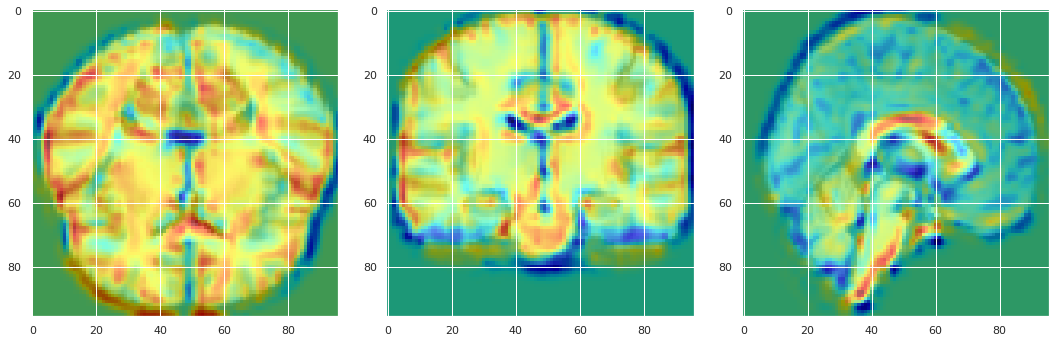

Dataset used: {'Oasis3', 'Oasis1'}


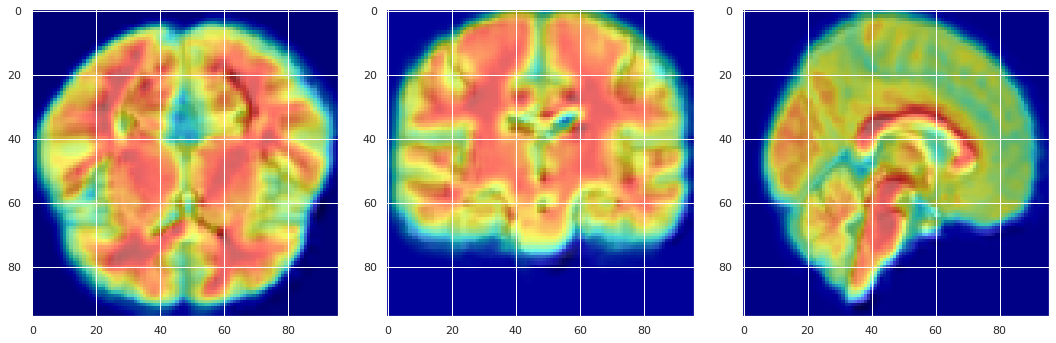

In [20]:
dataset_list = ["IXI", "Dallas", "Oasis1", "Oasis3"]
for idx, _dict in single_min.items():

    print(f"Dataset used: {set(dataset_list) - set(_dict['dataset'])}")
    plot_vismap(AVG, -single_min[idx]["npy"], masked=False);

In [6]:
def make_mp4(npy_list, fname=None, interval=500, dpi=100):

    print(f"Total {len(npy_list)} runs.")

    fig, axes = plt.subplots(ncols=3, figsize=(15, 6))
    title = fname.split("/")[-1].split(".mp4")[0]
    fig.suptitle(f"{title}")
    camera = Camera(fig)
    # for idx, _npy_path in enumerate(sorted(random.sample(npy_list, 10))):
    for idx, _npy_path in enumerate(npy_list):

        brain = check_type(AVG)
        vismap = check_type(np.load(_npy_path))

        fig.tight_layout()
        alpha = 0.6
        # axes[0].set_title('Saggital')
        axes[0].imshow(brain[48, :, :], cmap="gray", interpolation="none")
        axes[0].imshow(vismap[48, :, :], cmap="jet", interpolation="none", alpha=alpha)

        # axes[1].set_title('Coronal')
        axes[1].imshow(brain[:, 48, :], cmap="gray", interpolation="none")
        axes[1].imshow(vismap[:, 48, :], cmap="jet", interpolation="none", alpha=alpha)

        # axes[2].set_title('Horizontal')
        axes[2].imshow(brain[:, :, 48], cmap="gray", interpolation="none")
        axes[2].imshow(vismap[:, :, 48], cmap="jet", interpolation="none", alpha=alpha)

        # plot_vismap(AVG, np.load(_npy_path), masked=False, title=title);
        camera.snap()

    if fname is None:
        pass

    else:
        if os.path.exists(fname):
            print(f"Same name of the file {fname} already exists. Please remove or rename")

        else:
            animation = camera.animate(interval=interval, blit=True)
            animation.save(
                fname,
                dpi=dpi,
                savefig_kwargs={
                    'frameon': False,
                    'pad_inches': 'tight'
                }
            )
    return

def show_single_run(npy_list):

    for idx, _npy_path in enumerate(npy_list):

        epoch = epoch_parser(_npy_path)
        print(f"Epoch {epoch} | Test MAE {test_maes[epoch]}")
        plot_vismap(AVG, np.load(_npy_path), masked=False);

24
Total 62 runs.


/tmp/ipykernel_4164052/1606544073.py:41: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


16
Total 62 runs.


/tmp/ipykernel_4164052/1606544073.py:41: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


33
Total 62 runs.


/tmp/ipykernel_4164052/1606544073.py:41: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


95
Total 62 runs.


/tmp/ipykernel_4164052/1606544073.py:41: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


31
Total 62 runs.


/tmp/ipykernel_4164052/1606544073.py:41: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


99
Total 62 runs.


/tmp/ipykernel_4164052/1606544073.py:41: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


6
Total 62 runs.


/tmp/ipykernel_4164052/1606544073.py:41: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


5
Total 62 runs.


/tmp/ipykernel_4164052/1606544073.py:41: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


86
Total 62 runs.


/tmp/ipykernel_4164052/1606544073.py:41: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


87
Total 62 runs.


/tmp/ipykernel_4164052/1606544073.py:41: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


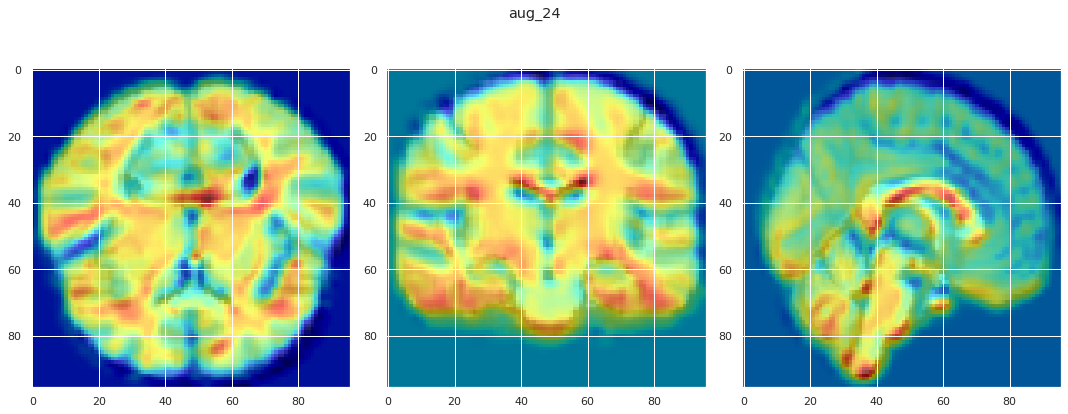

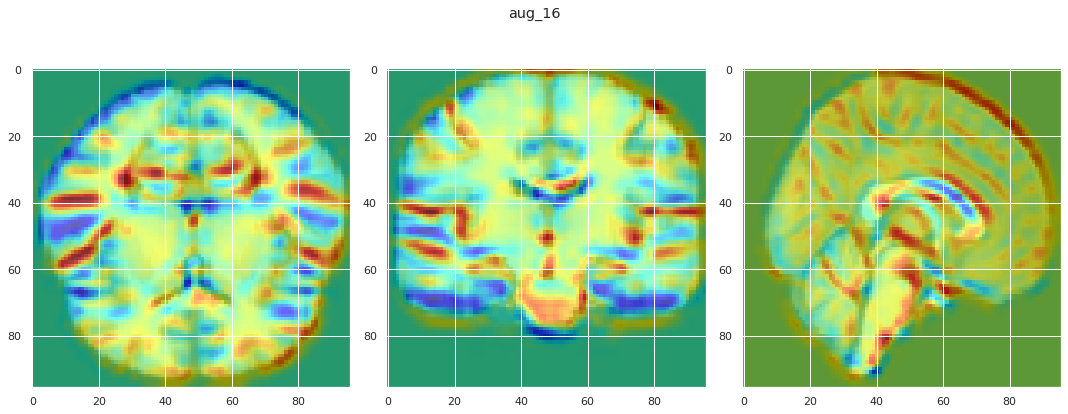

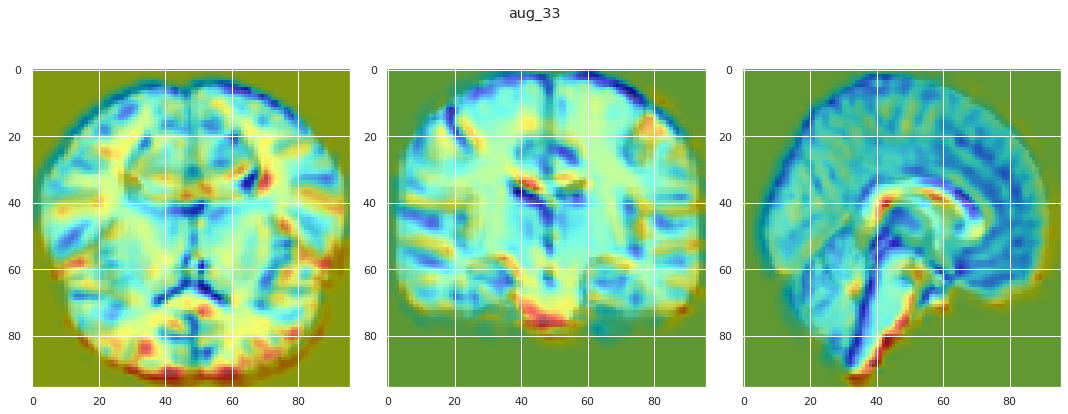

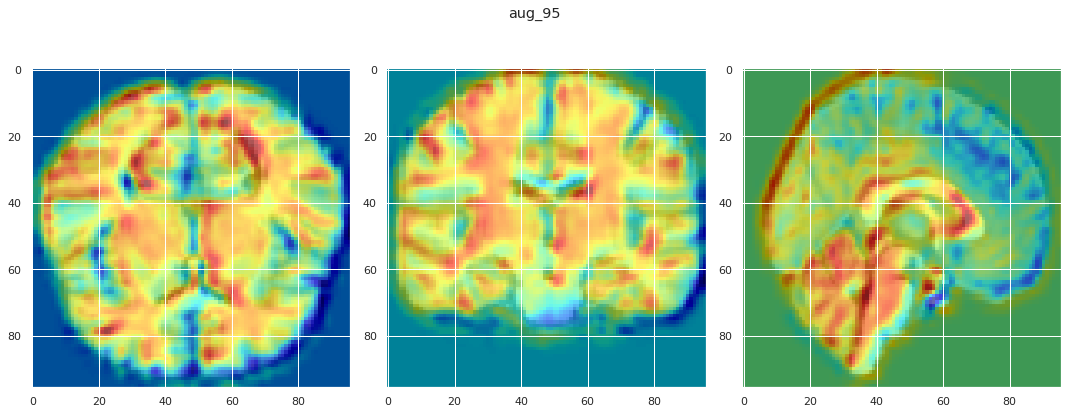

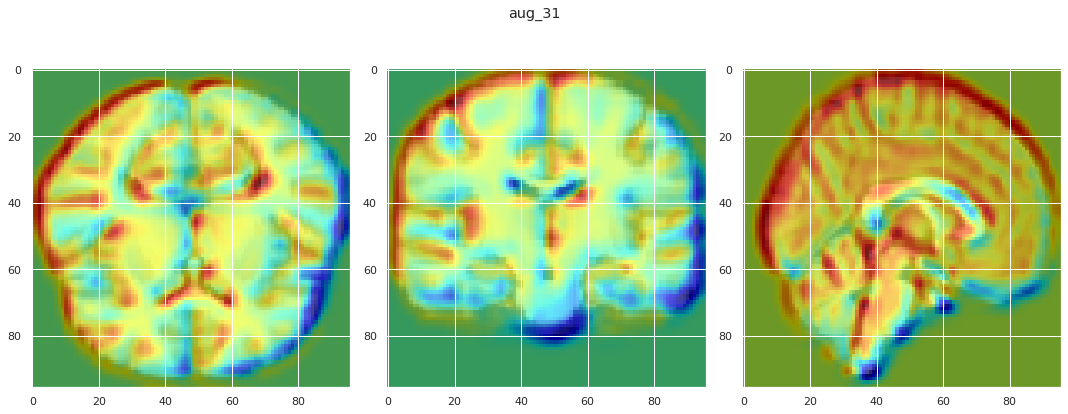

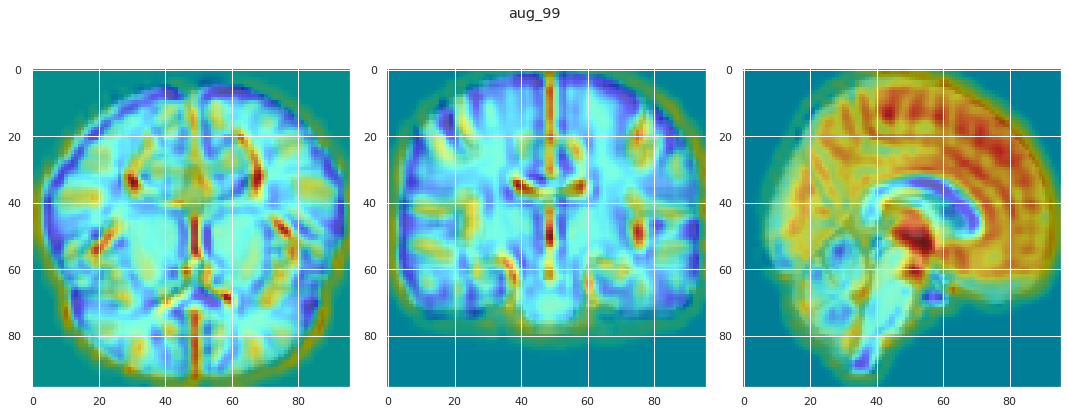

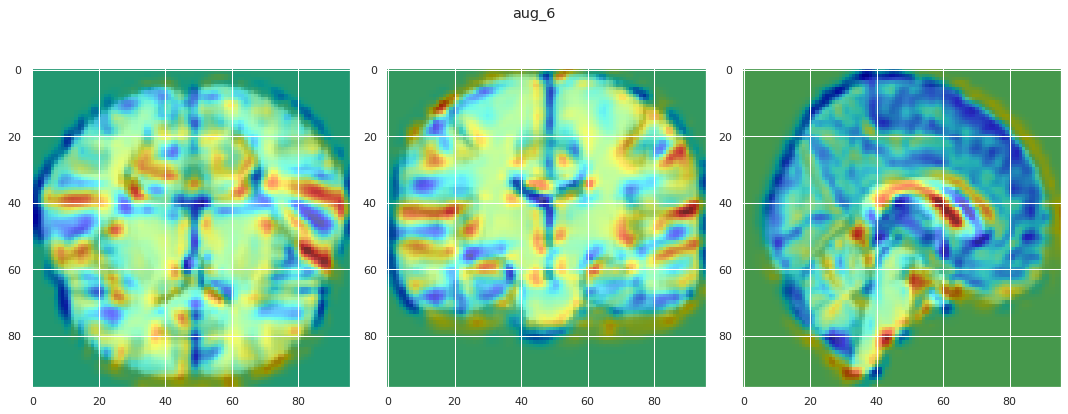

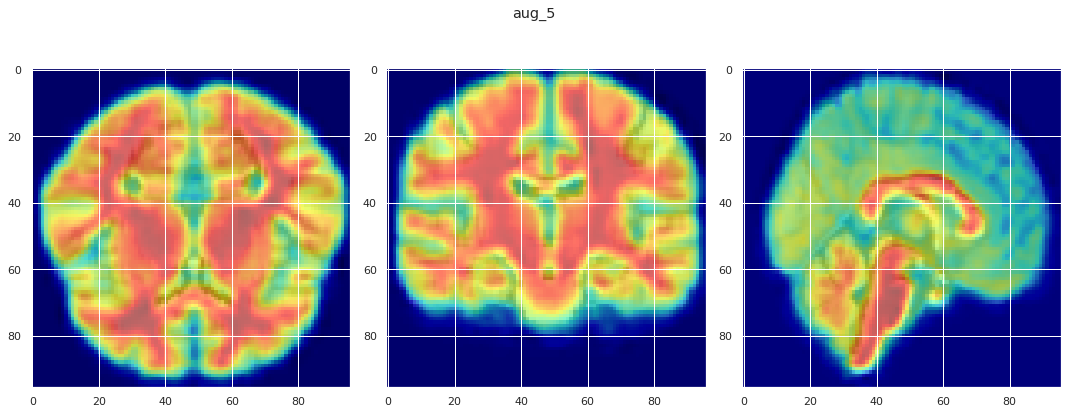

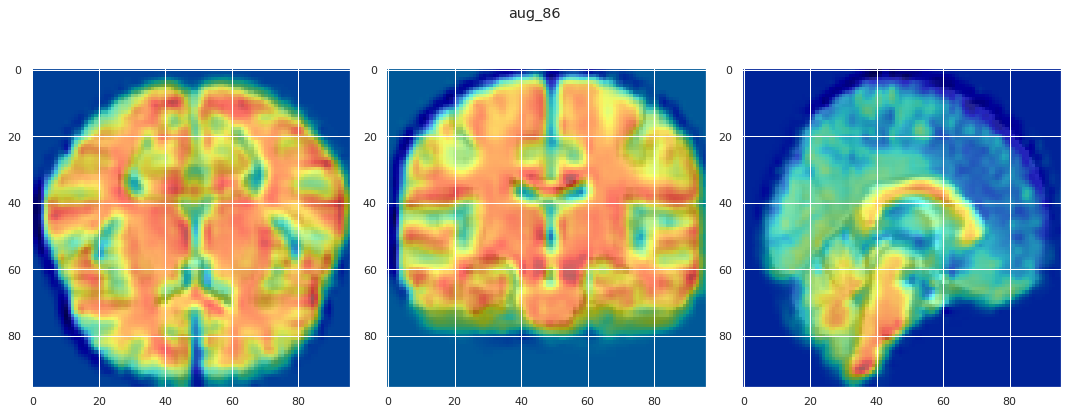

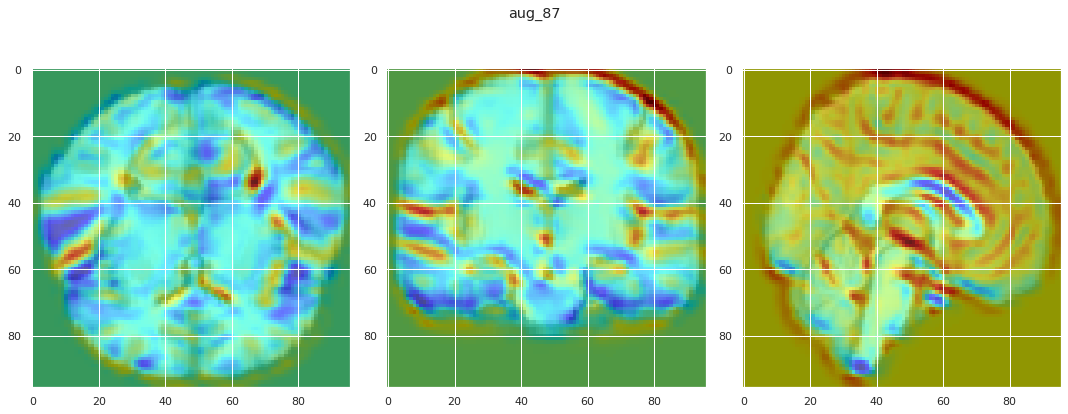

In [48]:
npy_root = sorted(glob("../resnet256_augmentation_checkpoints/*"))

for idx in random.sample(range(100), 10):

    print(idx)
    npy_list = sorted(glob(npy_root[idx] + "/npy_std/layer0/*.npy"))
    make_mp4(npy_list, f"../miccai2022/evolve_mp4/aug_{idx}.mp4")

Use cuda:0 as a device.
Output from encoder is 256.
Total Number of parameters: 3634403
Total 63 runs.


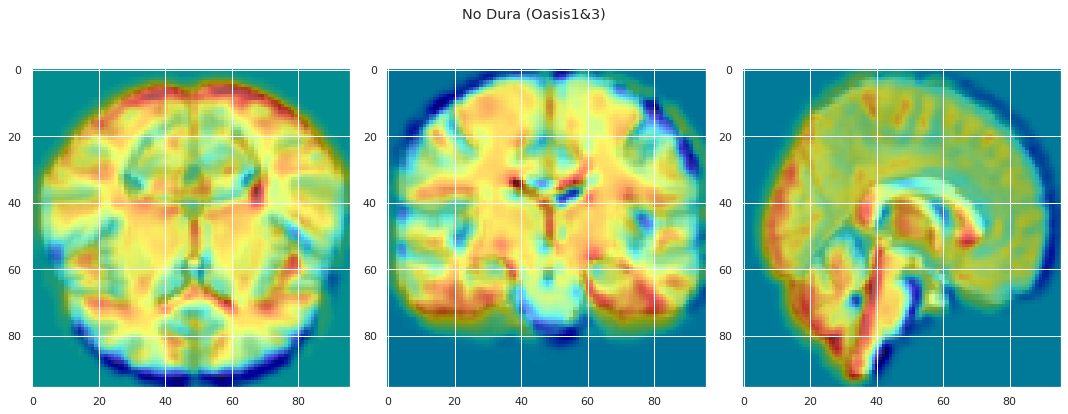

In [18]:
result_index = 1
npy_root = sorted(glob("../result/models/*"))[result_index]
npy_list = sorted(glob(npy_root + "/npy_std/layer0/*.npy"))
with open(npy_root + "/test.yml", "r") as f:
    test_prediction = yaml.load(f, Loader=yaml.Loader)
config = load_config(npy_root + "/config.yml")
trainer = MRITrainer(config)
gt_result = np.array(trainer.test_dataloader.dataset.data_ages)
test_maes = [MAE(gt_result, _prediction) for _prediction in test_prediction.values()]

print(f"Total {len(test_maes)} runs.")

fig, axes = plt.subplots(ncols=3, figsize=(15, 6))
fig.suptitle("No Dura (Oasis1&3)")
camera = Camera(fig)
# for idx, _npy_path in enumerate(sorted(random.sample(npy_list, 10))):
for idx, _npy_path in enumerate(npy_list):

    epoch = epoch_parser(_npy_path)
    # title = f"Epoch {epoch} | Test MAE {test_maes[epoch]}"

    brain = check_type(AVG)
    vismap = check_type(np.load(_npy_path))

    fig.tight_layout()
    alpha = 0.6
    # axes[0].set_title('Saggital')
    axes[0].imshow(brain[48, :, :], cmap="gray", interpolation="none")
    axes[0].imshow(vismap[48, :, :], cmap="jet", interpolation="none", alpha=alpha)

    # axes[1].set_title('Coronal')
    axes[1].imshow(brain[:, 48, :], cmap="gray", interpolation="none")
    axes[1].imshow(vismap[:, 48, :], cmap="jet", interpolation="none", alpha=alpha)

    # axes[2].set_title('Horizontal')
    axes[2].imshow(brain[:, :, 48], cmap="gray", interpolation="none")
    axes[2].imshow(vismap[:, :, 48], cmap="jet", interpolation="none", alpha=alpha)

    # plot_vismap(AVG, np.load(_npy_path), masked=False, title=title);
    camera.snap()

In [19]:
animation = camera.animate(interval=500, blit=True)

animation.save(
    'dura_no.mp4',
    dpi=100,
    savefig_kwargs={
        'frameon': False,
        'pad_inches': 'tight'
    }
)

/tmp/ipykernel_4163187/67401739.py:4: MatplotlibDeprecationWarning: save() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


In [ ]:
result_index = 1
npy_root = sorted(glob("../result/models/*"))[result_index]
npy_list = sorted(glob(npy_root + "/npy_std/layer0/*.npy"))
with open(npy_root + "/test.yml", "r") as f:
    test_prediction = yaml.load(f, Loader=yaml.Loader)
config = load_config(npy_root + "/config.yml")
trainer = MRITrainer(config)
gt_result = np.array(trainer.test_dataloader.dataset.data_ages)
test_maes = [MAE(gt_result, _prediction) for _prediction in test_prediction.values()]

print(f"Total {len(test_maes)} runs.")
for idx, _npy_path in enumerate(sorted(random.sample(npy_list, 10))):

    epoch = epoch_parser(_npy_path)
    print(f"Epoch {epoch} | Test MAE {test_maes[epoch]}")
    plot_vismap(AVG, np.load(_npy_path), masked=False);

In [ ]:
cfg = load_config(Path(checkpoint, "config.yml"))
cfg.registration = "mni"

cfg.force_cpu = True

saliency_mm_dir = Path(f"{checkpoint}/npy_mm/")
saliency_std_dir = Path(f"{checkpoint}/npy_std/")
os.makedirs(saliency_mm_dir, exist_ok=True)
os.makedirs(saliency_std_dir, exist_ok=True)
trainer = MRITrainer(cfg)
model = Assembled(trainer.models["encoder"], trainer.models["regressor"]).to("cuda")

saliency_map_ep_naive = dict()
for e in range(0, 151):
try:
    ckpt_dict, mae = load_model_ckpts(checkpoint, e)
    model.load_weight(ckpt_dict)
    logger.info(f"Load checkpoint epoch={e} | mae={mae}")
except:
    break

saliency_map_ep_naive[e] = []
for layer_idx, conv_layer in tqdm(enumerate(model.conv_layers()[:1])):

    layer_save_mm_dir = Path(f"{saliency_mm_dir}/layer{layer_idx}/")
    layer_save_std_dir = Path(f"{saliency_std_dir}/layer{layer_idx}/")

    os.makedirs(layer_save_mm_dir, exist_ok=True)
    os.makedirs(layer_save_std_dir, exist_ok=True)
    logger.info(f"Layer {layer_idx}: {conv_layer}")
    layer_gc = LayerGradCam(model, conv_layer)

    saliency_map = []
    for x, y, _ in trainer.test_dataloader:

        x, y = map(lambda x: x.to("cuda"), (x, y))
        attr = layer_gc.attribute(x)
        upsampled_attr = (
            LayerAttribution.interpolate(
                attr, (96, 96, 96), interpolate_mode="trilinear"
            )
            .cpu()
            .detach()
        )
        saliency_map.append(upsampled_attr)

    saliency_map = rearrange(
        torch.cat(saliency_map, dim=0), "b c h w d -> b (c h w d)"
    ).numpy()
    num_test = saliency_map.shape[0]

    scaler = MinMaxScaler()
    saliency_minmax = rearrange(
        scaler.fit_transform(saliency_map.T),
        "(h w d) b -> d w h b",
        h=96,
        w=96,
        d=96,
    ).T
    saliency_map_avg = saliency_minmax.sum(axis=0) / num_test
    # saliency_map_ep_naive[e].append((conv_layer, saliency_map_avg))
    np.save(
        f"{layer_save_mm_dir}/ep{str(e).zfill(3)}_mae{mae}.npy",
        saliency_map_avg,
    )

    scaler = StandardScaler()
    saliency_std = rearrange(
        scaler.fit_transform(saliency_map.T),
        "(h w d) b -> d w h b",
        h=96,
        w=96,
        d=96,
    ).T
    saliency_map_avg = saliency_std.sum(axis=0) / num_test
    # saliency_map_ep_naive[e].append((conv_layer, saliency_map_avg))
    np.save(
        f"{layer_save_std_dir}/ep{str(e).zfill(3)}_mae{mae}.npy",
        saliency_map_avg,
    )

clear_output()

## Single Run Evolving

In [ ]:
result_index = 1
npy_root = sorted(glob("../resnet256_naive_checkpoints/*"))[result_index]
npy_list = sorted(glob(npy_root + "/npy_std/layer0/*.npy"))

with open(npy_root + "/test.yml", "r") as f:
    test_prediction = yaml.load(f, Loader=yaml.Loader)
config = load_config(npy_root + "/config.yml")
trainer = MRITrainer(config)
gt_result = np.array(trainer.test_dataloader.dataset.data_ages)
test_maes = [MAE(gt_result, _prediction) for _prediction in test_prediction.values()]

print(f"Total {len(test_maes)} runs.")
for idx, _npy_path in enumerate(npy_list):

    epoch = epoch_parser(_npy_path)
    print(f"Epoch {epoch} | Test MAE {test_maes[epoch]}")
    plot_vismap(AVG, np.load(_npy_path), masked=False);

## Draw Histogram

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

label = pd.read_csv("../brainmask_mni/label.csv")
train, test = train_test_split(label, test_size=.1, random_state=42)

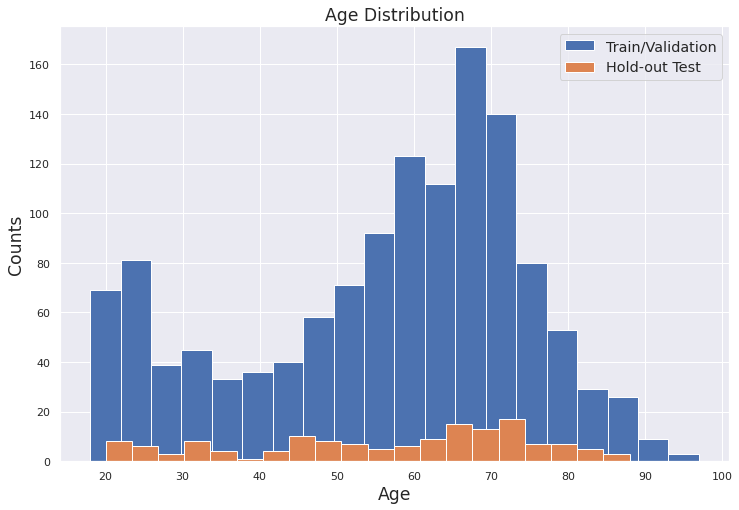

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Age Distribution", size="x-large")
ax.set_xlabel("Age", size="x-large")
ax.set_ylabel("Counts", size="x-large")
train.age.hist(ax=ax, bins=20, label='Train/Validation');
test.age.hist(ax=ax, bins=20, label='Hold-out Test');
ax.legend(prop={"size": "large"})

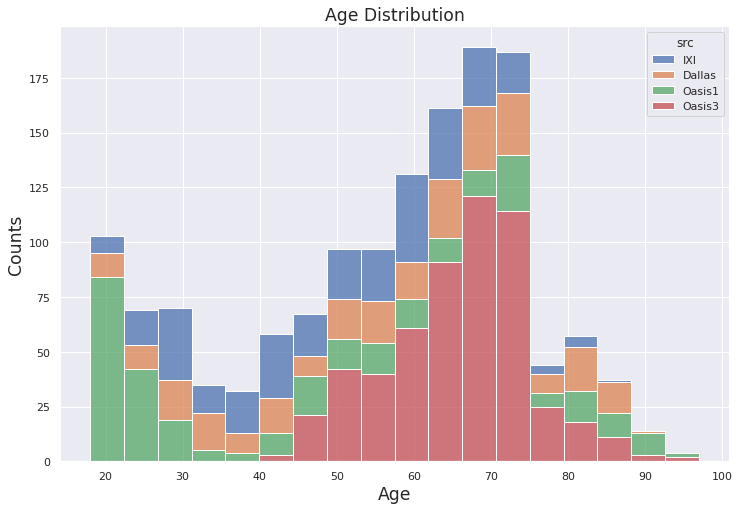

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Age Distribution", size="x-large")
ax.set_xlabel("Age", size="x-large")
ax.set_ylabel("Counts", size="x-large")
sns.histplot(data=label, x="age", hue="src", multiple="stack", ax=ax);

In [23]:
5.946 / 7.256

0.8194597574421169

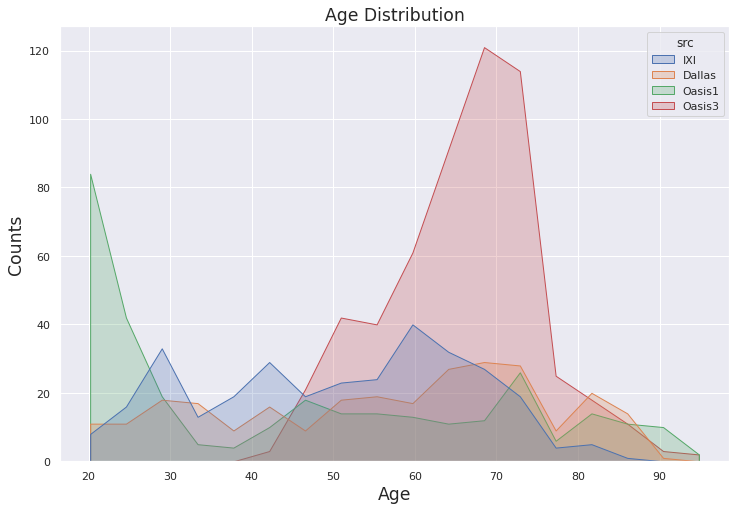

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Age Distribution", size="x-large")
ax.set_xlabel("Age", size="x-large")
ax.set_ylabel("Counts", size="x-large")
sns.histplot(data=label, x="age", hue="src", element="poly", ax=ax);